In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
data_dir='data'
data_split='val'
classes = ("person", "dog", "motorcycle", "bear", "knife", "apple", "kite", "giraffe", "cat")

In [3]:
annFile=f'{data_dir}/coco/annotations/instances_{data_split}2017.json'

In [4]:
import torch.utils.data as data
from PIL import Image
import os
from datasets import ImageDataset, COCODataset

In [5]:
from torchvision import transforms
import torch.nn.functional as F
import torch

def pad_to_size(img: torch.Tensor, size):
    padded = torch.zeros(img.shape[0], size[1], size[0])
    padded[:, :img.shape[1], :img.shape[2]] = img
    return padded

mean, std = 0.1307, 0.3081
train_dataset = ImageDataset(f"{data_dir}/classy_coconut/train",
                             classes,
                               tfm=transforms.Compose([
                                 transforms.Normalize((mean,), (std,)),
                                 lambda x: pad_to_size(x, (512, 512))
                             ]))
dev_dataset = ImageDataset(f"{data_dir}/classy_coconut/val",
                            classes,
                            tfm=transforms.Compose([
                                transforms.Normalize((mean,), (std,)),
                                lambda x: pad_to_size(x, (512, 512))
                            ]))
n_classes = len(classes)

In [6]:
print(len(train_dataset))
print(len(dev_dataset))

17455
3656


In [7]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf', '#800080', '#808000', '#F08080']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [8]:
batch_size = 2
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [9]:
# Set up data loaders
from datasets import SiameseImage

siamese_train_dataset = SiameseImage(train_dataset, True) # Returns pairs of images and target same/different
siamese_dev_dataset = SiameseImage(dev_dataset, False)
batch_size = 2
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_dev_loader = torch.utils.data.DataLoader(siamese_dev_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [10]:
fit(siamese_train_loader, siamese_dev_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/home/adrian/miniconda3/envs/julia/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/17455 (0%)]	Loss: 0.249769


Train: [200/17455 (1%)]	Loss: 0.399723


Train: [400/17455 (2%)]	Loss: 0.208757


Train: [600/17455 (3%)]	Loss: 0.169957


Train: [800/17455 (5%)]	Loss: 0.148199


Train: [1000/17455 (6%)]	Loss: 0.160529


Train: [1200/17455 (7%)]	Loss: 0.161588


Train: [1400/17455 (8%)]	Loss: 0.194330


Train: [1600/17455 (9%)]	Loss: 0.202110


Train: [1800/17455 (10%)]	Loss: 0.196327


Train: [2000/17455 (11%)]	Loss: 0.174253


Train: [2200/17455 (13%)]	Loss: 0.155872


Train: [2400/17455 (14%)]	Loss: 0.154570


Train: [2600/17455 (15%)]	Loss: 0.135112


Train: [2800/17455 (16%)]	Loss: 0.147917


Train: [3000/17455 (17%)]	Loss: 0.158266


Train: [3200/17455 (18%)]	Loss: 0.158721


Train: [3400/17455 (19%)]	Loss: 0.174305


Train: [3600/17455 (21%)]	Loss: 0.167575


Train: [3800/17455 (22%)]	Loss: 0.175003


Train: [4000/17455 (23%)]	Loss: 0.156886


Train: [4200/17455 (24%)]	Loss: 0.147035


Train: [4400/17455 (25%)]	Loss: 0.142298


Train: [4600/17455 (26%)]	Loss: 0.164196


Train: [4800/17455 (27%)]	Loss: 0.174413


Train: [5000/17455 (29%)]	Loss: 0.175558


Train: [5200/17455 (30%)]	Loss: 0.144508


Train: [5400/17455 (31%)]	Loss: 0.172558


Train: [5600/17455 (32%)]	Loss: 0.120011


Train: [5800/17455 (33%)]	Loss: 0.137044


Train: [6000/17455 (34%)]	Loss: 0.146420


Train: [6200/17455 (36%)]	Loss: 0.122158


Train: [6400/17455 (37%)]	Loss: 0.168389


Train: [6600/17455 (38%)]	Loss: 0.176461


Train: [6800/17455 (39%)]	Loss: 0.160748


Train: [7000/17455 (40%)]	Loss: 0.199228


Train: [7200/17455 (41%)]	Loss: 0.155060


Train: [7400/17455 (42%)]	Loss: 0.159328


Train: [7600/17455 (44%)]	Loss: 0.183377


Train: [7800/17455 (45%)]	Loss: 0.182005


Train: [8000/17455 (46%)]	Loss: 0.189810


Train: [8200/17455 (47%)]	Loss: 0.159744


Train: [8400/17455 (48%)]	Loss: 0.154592


Train: [8600/17455 (49%)]	Loss: 0.143354


Train: [8800/17455 (50%)]	Loss: 0.142540


Train: [9000/17455 (52%)]	Loss: 0.141324


Train: [9200/17455 (53%)]	Loss: 0.146425


Train: [9400/17455 (54%)]	Loss: 0.169410


Train: [9600/17455 (55%)]	Loss: 0.131161


Train: [9800/17455 (56%)]	Loss: 0.188660


Train: [10000/17455 (57%)]	Loss: 0.157021


Train: [10200/17455 (58%)]	Loss: 0.165827


Train: [10400/17455 (60%)]	Loss: 0.138995


Train: [10600/17455 (61%)]	Loss: 0.153414


Train: [10800/17455 (62%)]	Loss: 0.129782


Train: [11000/17455 (63%)]	Loss: 0.167181


Train: [11200/17455 (64%)]	Loss: 0.166786


Train: [11400/17455 (65%)]	Loss: 0.159049


Train: [11600/17455 (66%)]	Loss: 0.163195


Train: [11800/17455 (68%)]	Loss: 0.138045


Train: [12000/17455 (69%)]	Loss: 0.151674


Train: [12200/17455 (70%)]	Loss: 0.148340


Train: [12400/17455 (71%)]	Loss: 0.163305


Train: [12600/17455 (72%)]	Loss: 0.128410


Train: [12800/17455 (73%)]	Loss: 0.146520


Train: [13000/17455 (74%)]	Loss: 0.141922


Train: [13200/17455 (76%)]	Loss: 0.250043


Train: [13400/17455 (77%)]	Loss: 0.156495


Train: [13600/17455 (78%)]	Loss: 0.161978


Train: [13800/17455 (79%)]	Loss: 0.156595


Train: [14000/17455 (80%)]	Loss: 0.150384


Train: [14200/17455 (81%)]	Loss: 0.150044


Train: [14400/17455 (82%)]	Loss: 0.159928


Train: [14600/17455 (84%)]	Loss: 0.150541


Train: [14800/17455 (85%)]	Loss: 0.160412


Train: [15000/17455 (86%)]	Loss: 0.162153


Train: [15200/17455 (87%)]	Loss: 0.136682


Train: [15400/17455 (88%)]	Loss: 0.148338


Train: [15600/17455 (89%)]	Loss: 0.129522


Train: [15800/17455 (91%)]	Loss: 0.151930


Train: [16000/17455 (92%)]	Loss: 0.142714


Train: [16200/17455 (93%)]	Loss: 0.117814


Train: [16400/17455 (94%)]	Loss: 0.124227


Train: [16600/17455 (95%)]	Loss: 0.136590


Train: [16800/17455 (96%)]	Loss: 0.148076


Train: [17000/17455 (97%)]	Loss: 0.154781


Train: [17200/17455 (99%)]	Loss: 0.159906


Train: [17400/17455 (100%)]	Loss: 0.168500


Epoch: 1/20. Train set: Average loss: 0.1608
Epoch: 1/20. Validation set: Average loss: 0.1664


Train: [0/17455 (0%)]	Loss: 0.232250


Train: [200/17455 (1%)]	Loss: 0.170852


Train: [400/17455 (2%)]	Loss: 0.153613


Train: [600/17455 (3%)]	Loss: 0.175796


Train: [800/17455 (5%)]	Loss: 0.127888


Train: [1000/17455 (6%)]	Loss: 0.152487


Train: [1200/17455 (7%)]	Loss: 0.142758


Train: [1400/17455 (8%)]	Loss: 0.146263


Train: [1600/17455 (9%)]	Loss: 0.173714


Train: [1800/17455 (10%)]	Loss: 0.174980


Train: [2000/17455 (11%)]	Loss: 0.148370


Train: [2200/17455 (13%)]	Loss: 0.136652


Train: [2400/17455 (14%)]	Loss: 0.126961


Train: [2600/17455 (15%)]	Loss: 0.152627


Train: [2800/17455 (16%)]	Loss: 0.178314


Train: [3000/17455 (17%)]	Loss: 0.153692


Train: [3200/17455 (18%)]	Loss: 0.143267


Train: [3400/17455 (19%)]	Loss: 0.156314


Train: [3600/17455 (21%)]	Loss: 0.148714


Train: [3800/17455 (22%)]	Loss: 0.159709


Train: [4000/17455 (23%)]	Loss: 0.161811


Train: [4200/17455 (24%)]	Loss: 0.150279


Train: [4400/17455 (25%)]	Loss: 0.131184


Train: [4600/17455 (26%)]	Loss: 0.146559


Train: [4800/17455 (27%)]	Loss: 0.153083


Train: [5000/17455 (29%)]	Loss: 0.158707


Train: [5200/17455 (30%)]	Loss: 0.140300


Train: [5400/17455 (31%)]	Loss: 0.161073


Train: [5600/17455 (32%)]	Loss: 0.152420


Train: [5800/17455 (33%)]	Loss: 0.130124


Train: [6000/17455 (34%)]	Loss: 0.134186


Train: [6200/17455 (36%)]	Loss: 0.137548


Train: [6400/17455 (37%)]	Loss: 0.163446


Train: [6600/17455 (38%)]	Loss: 0.174398


Train: [6800/17455 (39%)]	Loss: 0.153010


Train: [7000/17455 (40%)]	Loss: 0.160043


Train: [7200/17455 (41%)]	Loss: 0.141078


Train: [7400/17455 (42%)]	Loss: 0.128099


Train: [7600/17455 (44%)]	Loss: 0.157018


Train: [7800/17455 (45%)]	Loss: 0.147060


Train: [8000/17455 (46%)]	Loss: 0.141073


Train: [8200/17455 (47%)]	Loss: 0.122978


Train: [8400/17455 (48%)]	Loss: 0.156854


Train: [8600/17455 (49%)]	Loss: 0.138314


Train: [8800/17455 (50%)]	Loss: 0.149300


Train: [9000/17455 (52%)]	Loss: 0.154373


Train: [9200/17455 (53%)]	Loss: 0.149284


Train: [9400/17455 (54%)]	Loss: 0.142554


Train: [9600/17455 (55%)]	Loss: 0.142619


Train: [9800/17455 (56%)]	Loss: 0.137929


Train: [10000/17455 (57%)]	Loss: 0.131046


Train: [10200/17455 (58%)]	Loss: 0.179363


Train: [10400/17455 (60%)]	Loss: 0.171131


Train: [10600/17455 (61%)]	Loss: 0.158831


Train: [10800/17455 (62%)]	Loss: 0.142805


Train: [11000/17455 (63%)]	Loss: 0.175375


Train: [11200/17455 (64%)]	Loss: 0.176583


Train: [11400/17455 (65%)]	Loss: 0.142277


Train: [11600/17455 (66%)]	Loss: 0.172997


Train: [11800/17455 (68%)]	Loss: 0.124030


Train: [12000/17455 (69%)]	Loss: 0.153816


Train: [12200/17455 (70%)]	Loss: 0.153864


Train: [12400/17455 (71%)]	Loss: 0.128065


Train: [12600/17455 (72%)]	Loss: 0.133898


Train: [12800/17455 (73%)]	Loss: 0.133415


Train: [13000/17455 (74%)]	Loss: 0.127074


Train: [13200/17455 (76%)]	Loss: 0.144999


Train: [13400/17455 (77%)]	Loss: 0.147572


Train: [13600/17455 (78%)]	Loss: 0.145690


Train: [13800/17455 (79%)]	Loss: 0.147000


Train: [14000/17455 (80%)]	Loss: 0.127510


Train: [14200/17455 (81%)]	Loss: 0.146023


Train: [14400/17455 (82%)]	Loss: 0.161852


Train: [14600/17455 (84%)]	Loss: 0.132458


Train: [14800/17455 (85%)]	Loss: 0.148917


Train: [15000/17455 (86%)]	Loss: 0.146470


Train: [15200/17455 (87%)]	Loss: 0.159939


Train: [15400/17455 (88%)]	Loss: 0.169046


Train: [15600/17455 (89%)]	Loss: 0.144618


Train: [15800/17455 (91%)]	Loss: 0.146821


Train: [16000/17455 (92%)]	Loss: 0.148433


Train: [16200/17455 (93%)]	Loss: 0.121119


Train: [16400/17455 (94%)]	Loss: 0.133786


Train: [16600/17455 (95%)]	Loss: 0.156651


Train: [16800/17455 (96%)]	Loss: 0.150090


Train: [17000/17455 (97%)]	Loss: 0.144436


Train: [17200/17455 (99%)]	Loss: 0.132391


Train: [17400/17455 (100%)]	Loss: 0.161742


Epoch: 2/20. Train set: Average loss: 0.1489
Epoch: 2/20. Validation set: Average loss: 0.1830


Train: [0/17455 (0%)]	Loss: 0.240418


Train: [200/17455 (1%)]	Loss: 0.164899


Train: [400/17455 (2%)]	Loss: 0.155186


Train: [600/17455 (3%)]	Loss: 0.154237


Train: [800/17455 (5%)]	Loss: 0.124311


Train: [1000/17455 (6%)]	Loss: 0.149421


Train: [1200/17455 (7%)]	Loss: 0.135894


Train: [1400/17455 (8%)]	Loss: 0.151528


Train: [1600/17455 (9%)]	Loss: 0.162241


Train: [1800/17455 (10%)]	Loss: 0.145080


Train: [2000/17455 (11%)]	Loss: 0.149292


Train: [2200/17455 (13%)]	Loss: 0.186729


Train: [2400/17455 (14%)]	Loss: 0.144598


Train: [2600/17455 (15%)]	Loss: 0.135470


Train: [2800/17455 (16%)]	Loss: 0.141576


Train: [3000/17455 (17%)]	Loss: 0.140305


Train: [3200/17455 (18%)]	Loss: 0.163538


Train: [3400/17455 (19%)]	Loss: 0.157901


Train: [3600/17455 (21%)]	Loss: 0.153038


Train: [3800/17455 (22%)]	Loss: 0.220411


Train: [4000/17455 (23%)]	Loss: 0.153805


Train: [4200/17455 (24%)]	Loss: 0.158473


Train: [4400/17455 (25%)]	Loss: 0.142642


Train: [4600/17455 (26%)]	Loss: 0.147929


Train: [4800/17455 (27%)]	Loss: 0.165495


Train: [5000/17455 (29%)]	Loss: 0.149111


Train: [5200/17455 (30%)]	Loss: 0.136743


Train: [5400/17455 (31%)]	Loss: 0.158158


Train: [5600/17455 (32%)]	Loss: 0.154157


Train: [5800/17455 (33%)]	Loss: 0.164267


Train: [6000/17455 (34%)]	Loss: 0.132032


Train: [6200/17455 (36%)]	Loss: 0.140307


Train: [6400/17455 (37%)]	Loss: 0.153218


Train: [6600/17455 (38%)]	Loss: 0.169368


Train: [6800/17455 (39%)]	Loss: 0.167732


Train: [7000/17455 (40%)]	Loss: 0.134213


Train: [7200/17455 (41%)]	Loss: 0.143869


Train: [7400/17455 (42%)]	Loss: 0.126947


Train: [7600/17455 (44%)]	Loss: 0.133778


Train: [7800/17455 (45%)]	Loss: 0.129971


Train: [8000/17455 (46%)]	Loss: 0.178823


Train: [8200/17455 (47%)]	Loss: 0.136015


Train: [8400/17455 (48%)]	Loss: 0.150110


Train: [8600/17455 (49%)]	Loss: 0.132164


Train: [8800/17455 (50%)]	Loss: 0.141070


Train: [9000/17455 (52%)]	Loss: 0.142002


Train: [9200/17455 (53%)]	Loss: 0.134930


Train: [9400/17455 (54%)]	Loss: 0.172127


Train: [9600/17455 (55%)]	Loss: 0.124126


Train: [9800/17455 (56%)]	Loss: 0.159815


Train: [10000/17455 (57%)]	Loss: 0.150654


Train: [10200/17455 (58%)]	Loss: 0.171805


Train: [10400/17455 (60%)]	Loss: 0.170425


Train: [10600/17455 (61%)]	Loss: 0.153693


Train: [10800/17455 (62%)]	Loss: 0.138248


Train: [11000/17455 (63%)]	Loss: 0.156235


Train: [11200/17455 (64%)]	Loss: 0.187366


Train: [11400/17455 (65%)]	Loss: 0.139149


Train: [11600/17455 (66%)]	Loss: 0.177000


Train: [11800/17455 (68%)]	Loss: 0.134076


Train: [12000/17455 (69%)]	Loss: 0.137351


Train: [12200/17455 (70%)]	Loss: 0.161731


Train: [12400/17455 (71%)]	Loss: 0.145522


Train: [12600/17455 (72%)]	Loss: 0.136431


Train: [12800/17455 (73%)]	Loss: 0.124350


Train: [13000/17455 (74%)]	Loss: 0.142309


Train: [13200/17455 (76%)]	Loss: 0.157032


Train: [13400/17455 (77%)]	Loss: 0.150173


Train: [13600/17455 (78%)]	Loss: 0.135298


Train: [13800/17455 (79%)]	Loss: 0.169626


Train: [14000/17455 (80%)]	Loss: 0.146548


Train: [14200/17455 (81%)]	Loss: 0.143407


Train: [14400/17455 (82%)]	Loss: 0.156850


Train: [14600/17455 (84%)]	Loss: 0.151149


Train: [14800/17455 (85%)]	Loss: 0.167579


Train: [15000/17455 (86%)]	Loss: 0.163166


Train: [15200/17455 (87%)]	Loss: 0.173547


Train: [15400/17455 (88%)]	Loss: 0.156414


Train: [15600/17455 (89%)]	Loss: 0.141990


Train: [15800/17455 (91%)]	Loss: 0.148168


Train: [16000/17455 (92%)]	Loss: 0.130548


Train: [16200/17455 (93%)]	Loss: 0.127717


Train: [16400/17455 (94%)]	Loss: 0.157924


Train: [16600/17455 (95%)]	Loss: 0.128151


Train: [16800/17455 (96%)]	Loss: 0.152806


Train: [17000/17455 (97%)]	Loss: 0.146146


Train: [17200/17455 (99%)]	Loss: 0.140640


Train: [17400/17455 (100%)]	Loss: 0.152626


Epoch: 3/20. Train set: Average loss: 0.1504
Epoch: 3/20. Validation set: Average loss: 0.1743


Train: [0/17455 (0%)]	Loss: 0.247890


Train: [200/17455 (1%)]	Loss: 0.158874


Train: [400/17455 (2%)]	Loss: 0.175730


Train: [600/17455 (3%)]	Loss: 0.167491


Train: [800/17455 (5%)]	Loss: 0.156698


Train: [1000/17455 (6%)]	Loss: 0.149582


Train: [1200/17455 (7%)]	Loss: 0.137217


Train: [1400/17455 (8%)]	Loss: 0.159085


Train: [1600/17455 (9%)]	Loss: 0.166803


Train: [1800/17455 (10%)]	Loss: 0.175349


Train: [2000/17455 (11%)]	Loss: 0.173520


Train: [2200/17455 (13%)]	Loss: 0.146960


Train: [2400/17455 (14%)]	Loss: 0.141032


Train: [2600/17455 (15%)]	Loss: 0.157218


Train: [2800/17455 (16%)]	Loss: 0.183003


Train: [3000/17455 (17%)]	Loss: 0.154904


Train: [3200/17455 (18%)]	Loss: 0.161856


Train: [3400/17455 (19%)]	Loss: 0.138752


Train: [3600/17455 (21%)]	Loss: 0.157984


Train: [3800/17455 (22%)]	Loss: 0.164090


Train: [4000/17455 (23%)]	Loss: 0.144651


Train: [4200/17455 (24%)]	Loss: 0.169034


Train: [4400/17455 (25%)]	Loss: 0.147382


Train: [4600/17455 (26%)]	Loss: 0.143013


Train: [4800/17455 (27%)]	Loss: 0.144251


Train: [5000/17455 (29%)]	Loss: 0.143188


Train: [5200/17455 (30%)]	Loss: 0.168845


Train: [5400/17455 (31%)]	Loss: 0.153297


Train: [5600/17455 (32%)]	Loss: 0.124243


Train: [5800/17455 (33%)]	Loss: 0.152866


Train: [6000/17455 (34%)]	Loss: 0.136751


Train: [6200/17455 (36%)]	Loss: 0.127965


Train: [6400/17455 (37%)]	Loss: 0.142095


Train: [6600/17455 (38%)]	Loss: 0.155830


Train: [6800/17455 (39%)]	Loss: 0.140526


Train: [7000/17455 (40%)]	Loss: 0.166974


Train: [7200/17455 (41%)]	Loss: 0.132470


Train: [7400/17455 (42%)]	Loss: 0.125663


Train: [7600/17455 (44%)]	Loss: 0.146301


Train: [7800/17455 (45%)]	Loss: 0.152823


Train: [8000/17455 (46%)]	Loss: 0.148220


Train: [8200/17455 (47%)]	Loss: 0.164155


Train: [8400/17455 (48%)]	Loss: 0.150756


Train: [8600/17455 (49%)]	Loss: 0.144740


Train: [8800/17455 (50%)]	Loss: 0.160156


Train: [9000/17455 (52%)]	Loss: 0.130182


Train: [9200/17455 (53%)]	Loss: 0.129973


Train: [9400/17455 (54%)]	Loss: 0.138461


Train: [9600/17455 (55%)]	Loss: 0.129493


Train: [9800/17455 (56%)]	Loss: 0.138752


Train: [10000/17455 (57%)]	Loss: 0.142481


Train: [10200/17455 (58%)]	Loss: 0.176691


Train: [10400/17455 (60%)]	Loss: 0.172918


Train: [10600/17455 (61%)]	Loss: 0.143769


Train: [10800/17455 (62%)]	Loss: 0.137740


Train: [11000/17455 (63%)]	Loss: 0.151494


Train: [11200/17455 (64%)]	Loss: 0.162036


Train: [11400/17455 (65%)]	Loss: 0.159453


Train: [11600/17455 (66%)]	Loss: 0.174364


Train: [11800/17455 (68%)]	Loss: 0.124742


Train: [12000/17455 (69%)]	Loss: 0.137438


Train: [12200/17455 (70%)]	Loss: 0.142687


Train: [12400/17455 (71%)]	Loss: 0.132685


Train: [12600/17455 (72%)]	Loss: 0.153425


Train: [12800/17455 (73%)]	Loss: 0.138073


Train: [13000/17455 (74%)]	Loss: 0.147414


Train: [13200/17455 (76%)]	Loss: 0.169288


Train: [13400/17455 (77%)]	Loss: 0.144493


Train: [13600/17455 (78%)]	Loss: 0.150876


Train: [13800/17455 (79%)]	Loss: 0.153670


Train: [14000/17455 (80%)]	Loss: 0.146182


Train: [14200/17455 (81%)]	Loss: 0.145805


Train: [14400/17455 (82%)]	Loss: 0.143325


Train: [14600/17455 (84%)]	Loss: 0.130757


Train: [14800/17455 (85%)]	Loss: 0.141922


Train: [15000/17455 (86%)]	Loss: 0.145324


Train: [15200/17455 (87%)]	Loss: 0.150932


Train: [15400/17455 (88%)]	Loss: 0.150250


Train: [15600/17455 (89%)]	Loss: 0.155175


Train: [15800/17455 (91%)]	Loss: 0.146649


Train: [16000/17455 (92%)]	Loss: 0.146229


Train: [16200/17455 (93%)]	Loss: 0.127928


Train: [16400/17455 (94%)]	Loss: 0.118862


Train: [16600/17455 (95%)]	Loss: 0.134106


Train: [16800/17455 (96%)]	Loss: 0.151202


Train: [17000/17455 (97%)]	Loss: 0.137786


Train: [17200/17455 (99%)]	Loss: 0.146924


Train: [17400/17455 (100%)]	Loss: 0.161093


Epoch: 4/20. Train set: Average loss: 0.1492
Epoch: 4/20. Validation set: Average loss: 0.1575


Train: [0/17455 (0%)]	Loss: 0.093097


Train: [200/17455 (1%)]	Loss: 0.141390


Train: [400/17455 (2%)]	Loss: 0.147520


Train: [600/17455 (3%)]	Loss: 0.159753


Train: [800/17455 (5%)]	Loss: 0.144849


Train: [1000/17455 (6%)]	Loss: 0.157494


Train: [1200/17455 (7%)]	Loss: 0.145416


Train: [1400/17455 (8%)]	Loss: 0.150960


Train: [1600/17455 (9%)]	Loss: 0.184178


Train: [1800/17455 (10%)]	Loss: 0.174984


Train: [2000/17455 (11%)]	Loss: 0.132425


Train: [2200/17455 (13%)]	Loss: 0.171259


Train: [2400/17455 (14%)]	Loss: 0.132384


Train: [2600/17455 (15%)]	Loss: 0.146000


Train: [2800/17455 (16%)]	Loss: 0.144846


Train: [3000/17455 (17%)]	Loss: 0.148377


Train: [3200/17455 (18%)]	Loss: 0.163129


Train: [3400/17455 (19%)]	Loss: 0.139321


Train: [3600/17455 (21%)]	Loss: 0.144223


Train: [3800/17455 (22%)]	Loss: 0.143765


Train: [4000/17455 (23%)]	Loss: 0.176342


Train: [4200/17455 (24%)]	Loss: 0.168388


Train: [4400/17455 (25%)]	Loss: 0.142935


Train: [4600/17455 (26%)]	Loss: 0.121004


Train: [4800/17455 (27%)]	Loss: 0.143514


Train: [5000/17455 (29%)]	Loss: 0.152445


Train: [5200/17455 (30%)]	Loss: 0.156186


Train: [5400/17455 (31%)]	Loss: 0.146895


Train: [5600/17455 (32%)]	Loss: 0.116950


Train: [5800/17455 (33%)]	Loss: 0.134753


Train: [6000/17455 (34%)]	Loss: 0.134306


Train: [6200/17455 (36%)]	Loss: 0.119807


Train: [6400/17455 (37%)]	Loss: 0.164889


Train: [6600/17455 (38%)]	Loss: 0.180472


Train: [6800/17455 (39%)]	Loss: 0.170445


Train: [7000/17455 (40%)]	Loss: 0.161977


Train: [7200/17455 (41%)]	Loss: 0.147586


Train: [7400/17455 (42%)]	Loss: 0.136114


Train: [7600/17455 (44%)]	Loss: 0.142694


Train: [7800/17455 (45%)]	Loss: 0.142977


Train: [8000/17455 (46%)]	Loss: 0.150957


Train: [8200/17455 (47%)]	Loss: 0.170786


Train: [8400/17455 (48%)]	Loss: 0.136831


Train: [8600/17455 (49%)]	Loss: 0.154469


Train: [8800/17455 (50%)]	Loss: 0.167402


Train: [9000/17455 (52%)]	Loss: 0.132003


Train: [9200/17455 (53%)]	Loss: 0.152017


Train: [9400/17455 (54%)]	Loss: 0.147029


Train: [9600/17455 (55%)]	Loss: 0.127269


Train: [9800/17455 (56%)]	Loss: 0.166195


Train: [10000/17455 (57%)]	Loss: 0.130387


Train: [10200/17455 (58%)]	Loss: 0.185572


Train: [10400/17455 (60%)]	Loss: 0.163975


Train: [10600/17455 (61%)]	Loss: 0.144419


Train: [10800/17455 (62%)]	Loss: 0.149310


Train: [11000/17455 (63%)]	Loss: 0.163869


Train: [11200/17455 (64%)]	Loss: 0.161143


Train: [11400/17455 (65%)]	Loss: 0.150527


Train: [11600/17455 (66%)]	Loss: 0.166363


Train: [11800/17455 (68%)]	Loss: 0.136373


Train: [12000/17455 (69%)]	Loss: 0.135526


Train: [12200/17455 (70%)]	Loss: 0.164696


Train: [12400/17455 (71%)]	Loss: 0.146110


Train: [12600/17455 (72%)]	Loss: 0.140635


Train: [12800/17455 (73%)]	Loss: 0.125222


Train: [13000/17455 (74%)]	Loss: 0.173578


Train: [13200/17455 (76%)]	Loss: 0.217746


Train: [13400/17455 (77%)]	Loss: 0.165169


Train: [13600/17455 (78%)]	Loss: 0.124975


Train: [13800/17455 (79%)]	Loss: 0.155609


Train: [14000/17455 (80%)]	Loss: 0.120748


Train: [14200/17455 (81%)]	Loss: 0.143583


Train: [14400/17455 (82%)]	Loss: 0.154594


Train: [14600/17455 (84%)]	Loss: 0.151402


Train: [14800/17455 (85%)]	Loss: 0.138113


Train: [15000/17455 (86%)]	Loss: 0.149317


Train: [15200/17455 (87%)]	Loss: 0.151140


Train: [15400/17455 (88%)]	Loss: 0.147392


Train: [15600/17455 (89%)]	Loss: 0.141002


Train: [15800/17455 (91%)]	Loss: 0.138212


Train: [16000/17455 (92%)]	Loss: 0.127952


Train: [16200/17455 (93%)]	Loss: 0.136182


Train: [16400/17455 (94%)]	Loss: 0.165257


Train: [16600/17455 (95%)]	Loss: 0.143910


Train: [16800/17455 (96%)]	Loss: 0.161700


Train: [17000/17455 (97%)]	Loss: 0.131927


Train: [17200/17455 (99%)]	Loss: 0.129139


Train: [17400/17455 (100%)]	Loss: 0.143684


Epoch: 5/20. Train set: Average loss: 0.1498
Epoch: 5/20. Validation set: Average loss: 0.1606


Train: [0/17455 (0%)]	Loss: 0.132589


Train: [200/17455 (1%)]	Loss: 0.153288


Train: [400/17455 (2%)]	Loss: 0.160441


Train: [600/17455 (3%)]	Loss: 0.160613


Train: [800/17455 (5%)]	Loss: 0.148094


Train: [1000/17455 (6%)]	Loss: 0.158253


Train: [1200/17455 (7%)]	Loss: 0.131313


Train: [1400/17455 (8%)]	Loss: 0.156342


Train: [1600/17455 (9%)]	Loss: 0.169819


Train: [1800/17455 (10%)]	Loss: 0.144898


Train: [2000/17455 (11%)]	Loss: 0.161153


Train: [2200/17455 (13%)]	Loss: 0.139816


Train: [2400/17455 (14%)]	Loss: 0.144207


Train: [2600/17455 (15%)]	Loss: 0.146580


Train: [2800/17455 (16%)]	Loss: 0.145180


Train: [3000/17455 (17%)]	Loss: 0.137511


Train: [3200/17455 (18%)]	Loss: 0.156359


Train: [3400/17455 (19%)]	Loss: 0.138932


Train: [3600/17455 (21%)]	Loss: 0.144498


Train: [3800/17455 (22%)]	Loss: 0.159750


Train: [4000/17455 (23%)]	Loss: 0.140007


Train: [4200/17455 (24%)]	Loss: 0.134428


Train: [4400/17455 (25%)]	Loss: 0.129006


Train: [4600/17455 (26%)]	Loss: 0.141115


Train: [4800/17455 (27%)]	Loss: 0.146522


Train: [5000/17455 (29%)]	Loss: 0.153458


Train: [5200/17455 (30%)]	Loss: 0.118367


Train: [5400/17455 (31%)]	Loss: 0.140460


Train: [5600/17455 (32%)]	Loss: 0.135555


Train: [5800/17455 (33%)]	Loss: 0.133826


Train: [6000/17455 (34%)]	Loss: 0.130854


Train: [6200/17455 (36%)]	Loss: 0.120706


Train: [6400/17455 (37%)]	Loss: 0.132677


Train: [6600/17455 (38%)]	Loss: 0.162044


Train: [6800/17455 (39%)]	Loss: 0.158684


Train: [7000/17455 (40%)]	Loss: 0.157898


Train: [7200/17455 (41%)]	Loss: 0.139091


Train: [7400/17455 (42%)]	Loss: 0.143667


Train: [7600/17455 (44%)]	Loss: 0.152560


Train: [7800/17455 (45%)]	Loss: 0.136978


Train: [8000/17455 (46%)]	Loss: 0.133072


Train: [8200/17455 (47%)]	Loss: 0.155738


Train: [8400/17455 (48%)]	Loss: 0.138964


Train: [8600/17455 (49%)]	Loss: 0.153136


Train: [8800/17455 (50%)]	Loss: 0.130737


Train: [9000/17455 (52%)]	Loss: 0.139541


Train: [9200/17455 (53%)]	Loss: 0.146568


Train: [9400/17455 (54%)]	Loss: 0.149023


Train: [9600/17455 (55%)]	Loss: 0.129452


Train: [9800/17455 (56%)]	Loss: 0.160258


Train: [10000/17455 (57%)]	Loss: 0.144895


Train: [10200/17455 (58%)]	Loss: 0.156777


Train: [10400/17455 (60%)]	Loss: 0.159075


Train: [10600/17455 (61%)]	Loss: 0.126814


Train: [10800/17455 (62%)]	Loss: 0.127944


Train: [11000/17455 (63%)]	Loss: 0.147859


Train: [11200/17455 (64%)]	Loss: 0.144641


Train: [11400/17455 (65%)]	Loss: 0.185216


Train: [11600/17455 (66%)]	Loss: 0.203678


Train: [11800/17455 (68%)]	Loss: 0.142966


Train: [12000/17455 (69%)]	Loss: 0.147543


Train: [12200/17455 (70%)]	Loss: 0.173218


Train: [12400/17455 (71%)]	Loss: 0.134104


Train: [12600/17455 (72%)]	Loss: 0.156394


Train: [12800/17455 (73%)]	Loss: 0.129578


Train: [13000/17455 (74%)]	Loss: 0.134970


Train: [13200/17455 (76%)]	Loss: 0.127188


Train: [13400/17455 (77%)]	Loss: 0.158366


Train: [13600/17455 (78%)]	Loss: 0.152836


Train: [13800/17455 (79%)]	Loss: 0.146766


Train: [14000/17455 (80%)]	Loss: 0.136008


Train: [14200/17455 (81%)]	Loss: 0.135326


Train: [14400/17455 (82%)]	Loss: 0.149326


Train: [14600/17455 (84%)]	Loss: 0.141209


Train: [14800/17455 (85%)]	Loss: 0.132072


Train: [15000/17455 (86%)]	Loss: 0.136178


Train: [15200/17455 (87%)]	Loss: 0.123876


Train: [15400/17455 (88%)]	Loss: 0.149829


Train: [15600/17455 (89%)]	Loss: 0.140798


Train: [15800/17455 (91%)]	Loss: 0.147930


Train: [16000/17455 (92%)]	Loss: 0.145100


Train: [16200/17455 (93%)]	Loss: 0.122613


Train: [16400/17455 (94%)]	Loss: 0.114844


Train: [16600/17455 (95%)]	Loss: 0.141033


Train: [16800/17455 (96%)]	Loss: 0.136401


Train: [17000/17455 (97%)]	Loss: 0.143937


Train: [17200/17455 (99%)]	Loss: 0.156839


Train: [17400/17455 (100%)]	Loss: 0.134741


Epoch: 6/20. Train set: Average loss: 0.1447
Epoch: 6/20. Validation set: Average loss: 0.1603


Train: [0/17455 (0%)]	Loss: 0.415893


Train: [200/17455 (1%)]	Loss: 0.164045


Train: [400/17455 (2%)]	Loss: 0.170532


Train: [600/17455 (3%)]	Loss: 0.149325


Train: [800/17455 (5%)]	Loss: 0.146611


Train: [1000/17455 (6%)]	Loss: 0.173265


Train: [1200/17455 (7%)]	Loss: 0.153099


Train: [1400/17455 (8%)]	Loss: 0.154855


Train: [1600/17455 (9%)]	Loss: 0.136831


Train: [1800/17455 (10%)]	Loss: 0.148455


Train: [2000/17455 (11%)]	Loss: 0.128395


Train: [2200/17455 (13%)]	Loss: 0.145582


Train: [2400/17455 (14%)]	Loss: 0.133079


Train: [2600/17455 (15%)]	Loss: 0.133208


Train: [2800/17455 (16%)]	Loss: 0.152139


Train: [3000/17455 (17%)]	Loss: 0.134496


Train: [3200/17455 (18%)]	Loss: 0.150151


Train: [3400/17455 (19%)]	Loss: 0.155164


Train: [3600/17455 (21%)]	Loss: 0.147428


Train: [3800/17455 (22%)]	Loss: 0.158209


Train: [4000/17455 (23%)]	Loss: 0.129923


Train: [4200/17455 (24%)]	Loss: 0.144630


Train: [4400/17455 (25%)]	Loss: 0.135451


Train: [4600/17455 (26%)]	Loss: 0.143433


Train: [4800/17455 (27%)]	Loss: 0.147789


Train: [5000/17455 (29%)]	Loss: 0.135292


Train: [5200/17455 (30%)]	Loss: 0.132669


Train: [5400/17455 (31%)]	Loss: 0.163474


Train: [5600/17455 (32%)]	Loss: 0.125534


Train: [5800/17455 (33%)]	Loss: 0.130584


Train: [6000/17455 (34%)]	Loss: 0.147765


Train: [6200/17455 (36%)]	Loss: 0.131471


Train: [6400/17455 (37%)]	Loss: 0.146863


Train: [6600/17455 (38%)]	Loss: 0.163717


Train: [6800/17455 (39%)]	Loss: 0.141392


Train: [7000/17455 (40%)]	Loss: 0.172253


Train: [7200/17455 (41%)]	Loss: 0.128003


Train: [7400/17455 (42%)]	Loss: 0.148556


Train: [7600/17455 (44%)]	Loss: 0.148699


Train: [7800/17455 (45%)]	Loss: 0.168173


Train: [8000/17455 (46%)]	Loss: 0.148698


Train: [8200/17455 (47%)]	Loss: 0.165733


Train: [8400/17455 (48%)]	Loss: 0.156073


Train: [8600/17455 (49%)]	Loss: 0.168776


Train: [8800/17455 (50%)]	Loss: 0.147018


Train: [9000/17455 (52%)]	Loss: 0.138346


Train: [9200/17455 (53%)]	Loss: 0.148691


Train: [9400/17455 (54%)]	Loss: 0.134553


Train: [9600/17455 (55%)]	Loss: 0.116631


Train: [9800/17455 (56%)]	Loss: 0.173524


Train: [10000/17455 (57%)]	Loss: 0.139300


Train: [10200/17455 (58%)]	Loss: 0.200502


Train: [10400/17455 (60%)]	Loss: 0.133374


Train: [10600/17455 (61%)]	Loss: 0.124074


Train: [10800/17455 (62%)]	Loss: 0.129822


Train: [11000/17455 (63%)]	Loss: 0.162717


Train: [11200/17455 (64%)]	Loss: 0.140370


Train: [11400/17455 (65%)]	Loss: 0.159392


Train: [11600/17455 (66%)]	Loss: 0.192281


Train: [11800/17455 (68%)]	Loss: 0.142769


Train: [12000/17455 (69%)]	Loss: 0.168164


Train: [12200/17455 (70%)]	Loss: 0.150839


Train: [12400/17455 (71%)]	Loss: 0.145026


Train: [12600/17455 (72%)]	Loss: 0.132015


Train: [12800/17455 (73%)]	Loss: 0.136160


Train: [13000/17455 (74%)]	Loss: 0.143211


Train: [13200/17455 (76%)]	Loss: 0.150779


Train: [13400/17455 (77%)]	Loss: 0.141675


Train: [13600/17455 (78%)]	Loss: 0.130602


Train: [13800/17455 (79%)]	Loss: 0.158609


Train: [14000/17455 (80%)]	Loss: 0.129358


Train: [14200/17455 (81%)]	Loss: 0.137473


Train: [14400/17455 (82%)]	Loss: 0.131992


Train: [14600/17455 (84%)]	Loss: 0.129918


Train: [14800/17455 (85%)]	Loss: 0.141899


Train: [15000/17455 (86%)]	Loss: 0.154081


Train: [15200/17455 (87%)]	Loss: 0.155202


Train: [15400/17455 (88%)]	Loss: 0.183372


Train: [15600/17455 (89%)]	Loss: 0.152005


Train: [15800/17455 (91%)]	Loss: 0.151560


Train: [16000/17455 (92%)]	Loss: 0.136204


Train: [16200/17455 (93%)]	Loss: 0.114396


Train: [16400/17455 (94%)]	Loss: 0.136768


Train: [16600/17455 (95%)]	Loss: 0.147647


Train: [16800/17455 (96%)]	Loss: 0.168464


Train: [17000/17455 (97%)]	Loss: 0.137106


Train: [17200/17455 (99%)]	Loss: 0.138966


Train: [17400/17455 (100%)]	Loss: 0.136362


Epoch: 7/20. Train set: Average loss: 0.1471
Epoch: 7/20. Validation set: Average loss: 0.1568


Train: [0/17455 (0%)]	Loss: 0.290435


Train: [200/17455 (1%)]	Loss: 0.171806


Train: [400/17455 (2%)]	Loss: 0.158178


Train: [600/17455 (3%)]	Loss: 0.166430


Train: [800/17455 (5%)]	Loss: 0.136027


Train: [1000/17455 (6%)]	Loss: 0.152665


Train: [1200/17455 (7%)]	Loss: 0.145544


Train: [1400/17455 (8%)]	Loss: 0.161116


Train: [1600/17455 (9%)]	Loss: 0.165150


Train: [1800/17455 (10%)]	Loss: 0.178452


Train: [2000/17455 (11%)]	Loss: 0.148613


Train: [2200/17455 (13%)]	Loss: 0.146225


Train: [2400/17455 (14%)]	Loss: 0.145587


Train: [2600/17455 (15%)]	Loss: 0.149109


Train: [2800/17455 (16%)]	Loss: 0.160190


Train: [3000/17455 (17%)]	Loss: 0.142233


Train: [3200/17455 (18%)]	Loss: 0.153249


Train: [3400/17455 (19%)]	Loss: 0.132103


Train: [3600/17455 (21%)]	Loss: 0.157601


Train: [3800/17455 (22%)]	Loss: 0.155555


Train: [4000/17455 (23%)]	Loss: 0.153984


Train: [4200/17455 (24%)]	Loss: 0.147156


Train: [4400/17455 (25%)]	Loss: 0.143328


Train: [4600/17455 (26%)]	Loss: 0.147448


Train: [4800/17455 (27%)]	Loss: 0.139971


Train: [5000/17455 (29%)]	Loss: 0.160323


Train: [5200/17455 (30%)]	Loss: 0.133319


Train: [5400/17455 (31%)]	Loss: 0.131596


Train: [5600/17455 (32%)]	Loss: 0.139869


Train: [5800/17455 (33%)]	Loss: 0.134478


Train: [6000/17455 (34%)]	Loss: 0.146454


Train: [6200/17455 (36%)]	Loss: 0.134799


Train: [6400/17455 (37%)]	Loss: 0.151198


Train: [6600/17455 (38%)]	Loss: 0.149836


Train: [6800/17455 (39%)]	Loss: 0.154788


Train: [7000/17455 (40%)]	Loss: 0.163262


Train: [7200/17455 (41%)]	Loss: 0.130303


Train: [7400/17455 (42%)]	Loss: 0.134521


Train: [7600/17455 (44%)]	Loss: 0.139175


Train: [7800/17455 (45%)]	Loss: 0.146057


Train: [8000/17455 (46%)]	Loss: 0.152580


Train: [8200/17455 (47%)]	Loss: 0.153134


Train: [8400/17455 (48%)]	Loss: 0.139672


Train: [8600/17455 (49%)]	Loss: 0.152395


Train: [8800/17455 (50%)]	Loss: 0.137814


Train: [9000/17455 (52%)]	Loss: 0.131272


Train: [9200/17455 (53%)]	Loss: 0.140053


Train: [9400/17455 (54%)]	Loss: 0.140276


Train: [9600/17455 (55%)]	Loss: 0.130364


Train: [9800/17455 (56%)]	Loss: 0.152693


Train: [10000/17455 (57%)]	Loss: 0.143561


Train: [10200/17455 (58%)]	Loss: 0.150019


Train: [10400/17455 (60%)]	Loss: 0.147367


Train: [10600/17455 (61%)]	Loss: 0.140891


Train: [10800/17455 (62%)]	Loss: 0.135132


Train: [11000/17455 (63%)]	Loss: 0.139652


Train: [11200/17455 (64%)]	Loss: 0.127041


Train: [11400/17455 (65%)]	Loss: 0.150947


Train: [11600/17455 (66%)]	Loss: 0.183140


Train: [11800/17455 (68%)]	Loss: 0.138932


Train: [12000/17455 (69%)]	Loss: 0.127051


Train: [12200/17455 (70%)]	Loss: 0.132431


Train: [12400/17455 (71%)]	Loss: 0.143223


Train: [12600/17455 (72%)]	Loss: 0.139832


Train: [12800/17455 (73%)]	Loss: 0.123439


Train: [13000/17455 (74%)]	Loss: 0.128350


Train: [13200/17455 (76%)]	Loss: 0.151306


Train: [13400/17455 (77%)]	Loss: 0.151638


Train: [13600/17455 (78%)]	Loss: 0.148153


Train: [13800/17455 (79%)]	Loss: 0.140043


Train: [14000/17455 (80%)]	Loss: 0.139905


Train: [14200/17455 (81%)]	Loss: 0.131823


Train: [14400/17455 (82%)]	Loss: 0.134059


Train: [14600/17455 (84%)]	Loss: 0.135777


Train: [14800/17455 (85%)]	Loss: 0.138881


Train: [15000/17455 (86%)]	Loss: 0.131086


Train: [15200/17455 (87%)]	Loss: 0.128931


Train: [15400/17455 (88%)]	Loss: 0.140205


Train: [15600/17455 (89%)]	Loss: 0.154909


Train: [15800/17455 (91%)]	Loss: 0.146735


Train: [16000/17455 (92%)]	Loss: 0.127693


Train: [16200/17455 (93%)]	Loss: 0.134588


Train: [16400/17455 (94%)]	Loss: 0.142809


Train: [16600/17455 (95%)]	Loss: 0.129630


Train: [16800/17455 (96%)]	Loss: 0.124894


Train: [17000/17455 (97%)]	Loss: 0.135079


Train: [17200/17455 (99%)]	Loss: 0.145876


Train: [17400/17455 (100%)]	Loss: 0.134635


Epoch: 8/20. Train set: Average loss: 0.1441
Epoch: 8/20. Validation set: Average loss: 0.1459


Train: [0/17455 (0%)]	Loss: 0.119008


Train: [200/17455 (1%)]	Loss: 0.144790


Train: [400/17455 (2%)]	Loss: 0.135854


Train: [600/17455 (3%)]	Loss: 0.144947


Train: [800/17455 (5%)]	Loss: 0.134665


Train: [1000/17455 (6%)]	Loss: 0.139843


Train: [1200/17455 (7%)]	Loss: 0.128776


Train: [1400/17455 (8%)]	Loss: 0.143021


Train: [1600/17455 (9%)]	Loss: 0.152520


Train: [1800/17455 (10%)]	Loss: 0.142833


Train: [2000/17455 (11%)]	Loss: 0.130666


Train: [2200/17455 (13%)]	Loss: 0.131443


Train: [2400/17455 (14%)]	Loss: 0.124203


Train: [2600/17455 (15%)]	Loss: 0.148523


Train: [2800/17455 (16%)]	Loss: 0.134838


Train: [3000/17455 (17%)]	Loss: 0.137822


Train: [3200/17455 (18%)]	Loss: 0.138716


Train: [3400/17455 (19%)]	Loss: 0.153233


Train: [3600/17455 (21%)]	Loss: 0.138387


Train: [3800/17455 (22%)]	Loss: 0.143766


Train: [4000/17455 (23%)]	Loss: 0.125343


Train: [4200/17455 (24%)]	Loss: 0.150335


Train: [4400/17455 (25%)]	Loss: 0.131167


Train: [4600/17455 (26%)]	Loss: 0.127542


Train: [4800/17455 (27%)]	Loss: 0.148577


Train: [5000/17455 (29%)]	Loss: 0.162719


Train: [5200/17455 (30%)]	Loss: 0.150810


Train: [5400/17455 (31%)]	Loss: 0.129486


Train: [5600/17455 (32%)]	Loss: 0.120962


Train: [5800/17455 (33%)]	Loss: 0.124967


Train: [6000/17455 (34%)]	Loss: 0.142871


Train: [6200/17455 (36%)]	Loss: 0.135983


Train: [6400/17455 (37%)]	Loss: 0.143445


Train: [6600/17455 (38%)]	Loss: 0.139171


Train: [6800/17455 (39%)]	Loss: 0.155123


Train: [7000/17455 (40%)]	Loss: 0.135447


Train: [7200/17455 (41%)]	Loss: 0.135649


Train: [7400/17455 (42%)]	Loss: 0.132420


Train: [7600/17455 (44%)]	Loss: 0.142545


Train: [7800/17455 (45%)]	Loss: 0.129704


Train: [8000/17455 (46%)]	Loss: 0.134300


Train: [8200/17455 (47%)]	Loss: 0.137038


Train: [8400/17455 (48%)]	Loss: 0.152916


Train: [8600/17455 (49%)]	Loss: 0.142188


Train: [8800/17455 (50%)]	Loss: 0.125206


Train: [9000/17455 (52%)]	Loss: 0.130942


Train: [9200/17455 (53%)]	Loss: 0.130727


Train: [9400/17455 (54%)]	Loss: 0.143943


Train: [9600/17455 (55%)]	Loss: 0.124233


Train: [9800/17455 (56%)]	Loss: 0.123082


Train: [10000/17455 (57%)]	Loss: 0.143835


Train: [10200/17455 (58%)]	Loss: 0.142250


Train: [10400/17455 (60%)]	Loss: 0.139648


Train: [10600/17455 (61%)]	Loss: 0.141268


Train: [10800/17455 (62%)]	Loss: 0.130299


Train: [11000/17455 (63%)]	Loss: 0.129098


Train: [11200/17455 (64%)]	Loss: 0.127215


Train: [11400/17455 (65%)]	Loss: 0.145909


Train: [11600/17455 (66%)]	Loss: 0.145592


Train: [11800/17455 (68%)]	Loss: 0.127785


Train: [12000/17455 (69%)]	Loss: 0.126060


Train: [12200/17455 (70%)]	Loss: 0.141773


Train: [12400/17455 (71%)]	Loss: 0.153925


Train: [12600/17455 (72%)]	Loss: 0.131429


Train: [12800/17455 (73%)]	Loss: 0.133622


Train: [13000/17455 (74%)]	Loss: 0.121798


Train: [13200/17455 (76%)]	Loss: 0.143479


Train: [13400/17455 (77%)]	Loss: 0.124642


Train: [13600/17455 (78%)]	Loss: 0.126862


Train: [13800/17455 (79%)]	Loss: 0.136173


Train: [14000/17455 (80%)]	Loss: 0.124607


Train: [14200/17455 (81%)]	Loss: 0.146556


Train: [14400/17455 (82%)]	Loss: 0.119365


Train: [14600/17455 (84%)]	Loss: 0.130971


Train: [14800/17455 (85%)]	Loss: 0.133098


Train: [15000/17455 (86%)]	Loss: 0.144741


Train: [15200/17455 (87%)]	Loss: 0.128209


Train: [15400/17455 (88%)]	Loss: 0.129172


Train: [15600/17455 (89%)]	Loss: 0.131258


Train: [15800/17455 (91%)]	Loss: 0.132535


Train: [16000/17455 (92%)]	Loss: 0.133914


Train: [16200/17455 (93%)]	Loss: 0.122577


Train: [16400/17455 (94%)]	Loss: 0.123189


Train: [16600/17455 (95%)]	Loss: 0.130529


Train: [16800/17455 (96%)]	Loss: 0.123269


Train: [17000/17455 (97%)]	Loss: 0.125278


Train: [17200/17455 (99%)]	Loss: 0.121165


Train: [17400/17455 (100%)]	Loss: 0.145581


Epoch: 9/20. Train set: Average loss: 0.1358
Epoch: 9/20. Validation set: Average loss: 0.1447


Train: [0/17455 (0%)]	Loss: 0.273646


Train: [200/17455 (1%)]	Loss: 0.130032


Train: [400/17455 (2%)]	Loss: 0.134321


Train: [600/17455 (3%)]	Loss: 0.141469


Train: [800/17455 (5%)]	Loss: 0.126140


Train: [1000/17455 (6%)]	Loss: 0.133794


Train: [1200/17455 (7%)]	Loss: 0.130100


Train: [1400/17455 (8%)]	Loss: 0.136665


Train: [1600/17455 (9%)]	Loss: 0.131705


Train: [1800/17455 (10%)]	Loss: 0.157705


Train: [2000/17455 (11%)]	Loss: 0.141117


Train: [2200/17455 (13%)]	Loss: 0.126980


Train: [2400/17455 (14%)]	Loss: 0.136653


Train: [2600/17455 (15%)]	Loss: 0.138179


Train: [2800/17455 (16%)]	Loss: 0.134178


Train: [3000/17455 (17%)]	Loss: 0.133710


Train: [3200/17455 (18%)]	Loss: 0.144396


Train: [3400/17455 (19%)]	Loss: 0.139577


Train: [3600/17455 (21%)]	Loss: 0.137511


Train: [3800/17455 (22%)]	Loss: 0.134497


Train: [4000/17455 (23%)]	Loss: 0.125149


Train: [4200/17455 (24%)]	Loss: 0.149201


Train: [4400/17455 (25%)]	Loss: 0.129301


Train: [4600/17455 (26%)]	Loss: 0.121856


Train: [4800/17455 (27%)]	Loss: 0.121526


Train: [5000/17455 (29%)]	Loss: 0.137690


Train: [5200/17455 (30%)]	Loss: 0.131999


Train: [5400/17455 (31%)]	Loss: 0.117648


Train: [5600/17455 (32%)]	Loss: 0.138034


Train: [5800/17455 (33%)]	Loss: 0.117745


Train: [6000/17455 (34%)]	Loss: 0.131373


Train: [6200/17455 (36%)]	Loss: 0.127351


Train: [6400/17455 (37%)]	Loss: 0.133105


Train: [6600/17455 (38%)]	Loss: 0.130936


Train: [6800/17455 (39%)]	Loss: 0.149911


Train: [7000/17455 (40%)]	Loss: 0.135578


Train: [7200/17455 (41%)]	Loss: 0.139227


Train: [7400/17455 (42%)]	Loss: 0.133557


Train: [7600/17455 (44%)]	Loss: 0.129319


Train: [7800/17455 (45%)]	Loss: 0.129360


Train: [8000/17455 (46%)]	Loss: 0.131972


Train: [8200/17455 (47%)]	Loss: 0.132564


Train: [8400/17455 (48%)]	Loss: 0.138975


Train: [8600/17455 (49%)]	Loss: 0.122738


Train: [8800/17455 (50%)]	Loss: 0.132903


Train: [9000/17455 (52%)]	Loss: 0.133233


Train: [9200/17455 (53%)]	Loss: 0.136645


Train: [9400/17455 (54%)]	Loss: 0.139698


Train: [9600/17455 (55%)]	Loss: 0.136040


Train: [9800/17455 (56%)]	Loss: 0.128304


Train: [10000/17455 (57%)]	Loss: 0.130403


Train: [10200/17455 (58%)]	Loss: 0.134434


Train: [10400/17455 (60%)]	Loss: 0.122512


Train: [10600/17455 (61%)]	Loss: 0.131032


Train: [10800/17455 (62%)]	Loss: 0.138758


Train: [11000/17455 (63%)]	Loss: 0.127855


Train: [11200/17455 (64%)]	Loss: 0.152558


Train: [11400/17455 (65%)]	Loss: 0.142289


Train: [11600/17455 (66%)]	Loss: 0.141978


Train: [11800/17455 (68%)]	Loss: 0.140235


Train: [12000/17455 (69%)]	Loss: 0.148655


Train: [12200/17455 (70%)]	Loss: 0.143662


Train: [12400/17455 (71%)]	Loss: 0.132430


Train: [12600/17455 (72%)]	Loss: 0.134895


Train: [12800/17455 (73%)]	Loss: 0.129164


Train: [13000/17455 (74%)]	Loss: 0.141289


Train: [13200/17455 (76%)]	Loss: 0.143569


Train: [13400/17455 (77%)]	Loss: 0.136088


Train: [13600/17455 (78%)]	Loss: 0.113494


Train: [13800/17455 (79%)]	Loss: 0.128399


Train: [14000/17455 (80%)]	Loss: 0.127516


Train: [14200/17455 (81%)]	Loss: 0.127106


Train: [14400/17455 (82%)]	Loss: 0.143338


Train: [14600/17455 (84%)]	Loss: 0.133514


Train: [14800/17455 (85%)]	Loss: 0.141132


Train: [15000/17455 (86%)]	Loss: 0.138012


Train: [15200/17455 (87%)]	Loss: 0.135284


Train: [15400/17455 (88%)]	Loss: 0.146950


Train: [15600/17455 (89%)]	Loss: 0.128312


Train: [15800/17455 (91%)]	Loss: 0.129990


Train: [16000/17455 (92%)]	Loss: 0.126073


Train: [16200/17455 (93%)]	Loss: 0.124473


Train: [16400/17455 (94%)]	Loss: 0.127277


Train: [16600/17455 (95%)]	Loss: 0.124746


Train: [16800/17455 (96%)]	Loss: 0.129522


Train: [17000/17455 (97%)]	Loss: 0.123204


Train: [17200/17455 (99%)]	Loss: 0.130510


Train: [17400/17455 (100%)]	Loss: 0.138352


Epoch: 10/20. Train set: Average loss: 0.1338
Epoch: 10/20. Validation set: Average loss: 0.1477


Train: [0/17455 (0%)]	Loss: 0.202791


Train: [200/17455 (1%)]	Loss: 0.133049


Train: [400/17455 (2%)]	Loss: 0.137811


Train: [600/17455 (3%)]	Loss: 0.129677


Train: [800/17455 (5%)]	Loss: 0.145367


Train: [1000/17455 (6%)]	Loss: 0.141858


Train: [1200/17455 (7%)]	Loss: 0.134608


Train: [1400/17455 (8%)]	Loss: 0.142650


Train: [1600/17455 (9%)]	Loss: 0.136060


Train: [1800/17455 (10%)]	Loss: 0.141827


Train: [2000/17455 (11%)]	Loss: 0.132348


Train: [2200/17455 (13%)]	Loss: 0.115779


Train: [2400/17455 (14%)]	Loss: 0.128997


Train: [2600/17455 (15%)]	Loss: 0.139623


Train: [2800/17455 (16%)]	Loss: 0.129593


Train: [3000/17455 (17%)]	Loss: 0.135368


Train: [3200/17455 (18%)]	Loss: 0.130274


Train: [3400/17455 (19%)]	Loss: 0.142204


Train: [3600/17455 (21%)]	Loss: 0.131961


Train: [3800/17455 (22%)]	Loss: 0.133729


Train: [4000/17455 (23%)]	Loss: 0.131978


Train: [4200/17455 (24%)]	Loss: 0.133999


Train: [4400/17455 (25%)]	Loss: 0.152579


Train: [4600/17455 (26%)]	Loss: 0.125528


Train: [4800/17455 (27%)]	Loss: 0.125483


Train: [5000/17455 (29%)]	Loss: 0.130060


Train: [5200/17455 (30%)]	Loss: 0.139358


Train: [5400/17455 (31%)]	Loss: 0.128091


Train: [5600/17455 (32%)]	Loss: 0.128332


Train: [5800/17455 (33%)]	Loss: 0.121076


Train: [6000/17455 (34%)]	Loss: 0.123050


Train: [6200/17455 (36%)]	Loss: 0.131137


Train: [6400/17455 (37%)]	Loss: 0.123104


Train: [6600/17455 (38%)]	Loss: 0.139659


Train: [6800/17455 (39%)]	Loss: 0.135519


Train: [7000/17455 (40%)]	Loss: 0.132578


Train: [7200/17455 (41%)]	Loss: 0.141764


Train: [7400/17455 (42%)]	Loss: 0.127313


Train: [7600/17455 (44%)]	Loss: 0.141105


Train: [7800/17455 (45%)]	Loss: 0.147009


Train: [8000/17455 (46%)]	Loss: 0.136104


Train: [8200/17455 (47%)]	Loss: 0.117956


Train: [8400/17455 (48%)]	Loss: 0.140547


Train: [8600/17455 (49%)]	Loss: 0.128676


Train: [8800/17455 (50%)]	Loss: 0.130784


Train: [9000/17455 (52%)]	Loss: 0.122614


Train: [9200/17455 (53%)]	Loss: 0.113234


Train: [9400/17455 (54%)]	Loss: 0.123840


Train: [9600/17455 (55%)]	Loss: 0.130098


Train: [9800/17455 (56%)]	Loss: 0.145742


Train: [10000/17455 (57%)]	Loss: 0.150922


Train: [10200/17455 (58%)]	Loss: 0.144687


Train: [10400/17455 (60%)]	Loss: 0.122347


Train: [10600/17455 (61%)]	Loss: 0.129842


Train: [10800/17455 (62%)]	Loss: 0.141275


Train: [11000/17455 (63%)]	Loss: 0.116874


Train: [11200/17455 (64%)]	Loss: 0.132970


Train: [11400/17455 (65%)]	Loss: 0.143810


Train: [11600/17455 (66%)]	Loss: 0.133916


Train: [11800/17455 (68%)]	Loss: 0.111593


Train: [12000/17455 (69%)]	Loss: 0.135517


Train: [12200/17455 (70%)]	Loss: 0.147510


Train: [12400/17455 (71%)]	Loss: 0.136080


Train: [12600/17455 (72%)]	Loss: 0.117079


Train: [12800/17455 (73%)]	Loss: 0.123809


Train: [13000/17455 (74%)]	Loss: 0.124046


Train: [13200/17455 (76%)]	Loss: 0.119602


Train: [13400/17455 (77%)]	Loss: 0.118285


Train: [13600/17455 (78%)]	Loss: 0.128409


Train: [13800/17455 (79%)]	Loss: 0.125346


Train: [14000/17455 (80%)]	Loss: 0.120072


Train: [14200/17455 (81%)]	Loss: 0.132904


Train: [14400/17455 (82%)]	Loss: 0.130918


Train: [14600/17455 (84%)]	Loss: 0.128117


Train: [14800/17455 (85%)]	Loss: 0.147223


Train: [15000/17455 (86%)]	Loss: 0.131213


Train: [15200/17455 (87%)]	Loss: 0.127512


Train: [15400/17455 (88%)]	Loss: 0.150067


Train: [15600/17455 (89%)]	Loss: 0.120477


Train: [15800/17455 (91%)]	Loss: 0.129921


Train: [16000/17455 (92%)]	Loss: 0.127848


Train: [16200/17455 (93%)]	Loss: 0.115111


Train: [16400/17455 (94%)]	Loss: 0.126689


Train: [16600/17455 (95%)]	Loss: 0.127372


Train: [16800/17455 (96%)]	Loss: 0.125568


Train: [17000/17455 (97%)]	Loss: 0.129386


Train: [17200/17455 (99%)]	Loss: 0.114537


Train: [17400/17455 (100%)]	Loss: 0.137841


Epoch: 11/20. Train set: Average loss: 0.1315
Epoch: 11/20. Validation set: Average loss: 0.1486


Train: [0/17455 (0%)]	Loss: 0.127492


Train: [200/17455 (1%)]	Loss: 0.123342


Train: [400/17455 (2%)]	Loss: 0.124532


Train: [600/17455 (3%)]	Loss: 0.132845


Train: [800/17455 (5%)]	Loss: 0.132628


Train: [1000/17455 (6%)]	Loss: 0.137203


Train: [1200/17455 (7%)]	Loss: 0.135951


Train: [1400/17455 (8%)]	Loss: 0.129763


Train: [1600/17455 (9%)]	Loss: 0.123226


Train: [1800/17455 (10%)]	Loss: 0.152987


Train: [2000/17455 (11%)]	Loss: 0.118152


Train: [2200/17455 (13%)]	Loss: 0.115891


Train: [2400/17455 (14%)]	Loss: 0.113404


Train: [2600/17455 (15%)]	Loss: 0.126207


Train: [2800/17455 (16%)]	Loss: 0.133723


Train: [3000/17455 (17%)]	Loss: 0.134589


Train: [3200/17455 (18%)]	Loss: 0.133479


Train: [3400/17455 (19%)]	Loss: 0.132124


Train: [3600/17455 (21%)]	Loss: 0.134019


Train: [3800/17455 (22%)]	Loss: 0.138437


Train: [4000/17455 (23%)]	Loss: 0.128211


Train: [4200/17455 (24%)]	Loss: 0.135468


Train: [4400/17455 (25%)]	Loss: 0.143771


Train: [4600/17455 (26%)]	Loss: 0.123273


Train: [4800/17455 (27%)]	Loss: 0.128383


Train: [5000/17455 (29%)]	Loss: 0.137778


Train: [5200/17455 (30%)]	Loss: 0.139010


Train: [5400/17455 (31%)]	Loss: 0.127649


Train: [5600/17455 (32%)]	Loss: 0.124379


Train: [5800/17455 (33%)]	Loss: 0.123063


Train: [6000/17455 (34%)]	Loss: 0.136554


Train: [6200/17455 (36%)]	Loss: 0.131647


Train: [6400/17455 (37%)]	Loss: 0.136516


Train: [6600/17455 (38%)]	Loss: 0.132853


Train: [6800/17455 (39%)]	Loss: 0.131658


Train: [7000/17455 (40%)]	Loss: 0.138617


Train: [7200/17455 (41%)]	Loss: 0.119406


Train: [7400/17455 (42%)]	Loss: 0.121650


Train: [7600/17455 (44%)]	Loss: 0.122583


Train: [7800/17455 (45%)]	Loss: 0.134483


Train: [8000/17455 (46%)]	Loss: 0.133656


Train: [8200/17455 (47%)]	Loss: 0.116330


Train: [8400/17455 (48%)]	Loss: 0.134206


Train: [8600/17455 (49%)]	Loss: 0.149998


Train: [8800/17455 (50%)]	Loss: 0.127768


Train: [9000/17455 (52%)]	Loss: 0.122625


Train: [9200/17455 (53%)]	Loss: 0.126232


Train: [9400/17455 (54%)]	Loss: 0.139772


Train: [9600/17455 (55%)]	Loss: 0.122620


Train: [9800/17455 (56%)]	Loss: 0.143682


Train: [10000/17455 (57%)]	Loss: 0.124756


Train: [10200/17455 (58%)]	Loss: 0.142207


Train: [10400/17455 (60%)]	Loss: 0.126918


Train: [10600/17455 (61%)]	Loss: 0.113382


Train: [10800/17455 (62%)]	Loss: 0.132171


Train: [11000/17455 (63%)]	Loss: 0.141830


Train: [11200/17455 (64%)]	Loss: 0.147792


Train: [11400/17455 (65%)]	Loss: 0.124823


Train: [11600/17455 (66%)]	Loss: 0.151395


Train: [11800/17455 (68%)]	Loss: 0.122629


Train: [12000/17455 (69%)]	Loss: 0.127528


Train: [12200/17455 (70%)]	Loss: 0.123325


Train: [12400/17455 (71%)]	Loss: 0.123334


Train: [12600/17455 (72%)]	Loss: 0.136292


Train: [12800/17455 (73%)]	Loss: 0.118428


Train: [13000/17455 (74%)]	Loss: 0.110190


Train: [13200/17455 (76%)]	Loss: 0.113749


Train: [13400/17455 (77%)]	Loss: 0.136631


Train: [13600/17455 (78%)]	Loss: 0.122968


Train: [13800/17455 (79%)]	Loss: 0.131438


Train: [14000/17455 (80%)]	Loss: 0.127538


Train: [14200/17455 (81%)]	Loss: 0.119438


Train: [14400/17455 (82%)]	Loss: 0.134624


Train: [14600/17455 (84%)]	Loss: 0.118369


Train: [14800/17455 (85%)]	Loss: 0.120143


Train: [15000/17455 (86%)]	Loss: 0.124123


Train: [15200/17455 (87%)]	Loss: 0.126679


Train: [15400/17455 (88%)]	Loss: 0.138723


Train: [15600/17455 (89%)]	Loss: 0.134606


Train: [15800/17455 (91%)]	Loss: 0.124879


Train: [16000/17455 (92%)]	Loss: 0.127673


Train: [16200/17455 (93%)]	Loss: 0.117192


Train: [16400/17455 (94%)]	Loss: 0.119114


Train: [16600/17455 (95%)]	Loss: 0.107954


Train: [16800/17455 (96%)]	Loss: 0.126738


Train: [17000/17455 (97%)]	Loss: 0.118295


Train: [17200/17455 (99%)]	Loss: 0.116413


Train: [17400/17455 (100%)]	Loss: 0.136110


Epoch: 12/20. Train set: Average loss: 0.1289
Epoch: 12/20. Validation set: Average loss: 0.1501


Train: [0/17455 (0%)]	Loss: 0.012516


Train: [200/17455 (1%)]	Loss: 0.126205


Train: [400/17455 (2%)]	Loss: 0.134230


Train: [600/17455 (3%)]	Loss: 0.124766


Train: [800/17455 (5%)]	Loss: 0.129367


Train: [1000/17455 (6%)]	Loss: 0.133124


Train: [1200/17455 (7%)]	Loss: 0.127663


Train: [1400/17455 (8%)]	Loss: 0.123149


Train: [1600/17455 (9%)]	Loss: 0.127310


Train: [1800/17455 (10%)]	Loss: 0.124354


Train: [2000/17455 (11%)]	Loss: 0.129768


Train: [2200/17455 (13%)]	Loss: 0.104870


Train: [2400/17455 (14%)]	Loss: 0.127723


Train: [2600/17455 (15%)]	Loss: 0.124202


Train: [2800/17455 (16%)]	Loss: 0.125168


Train: [3000/17455 (17%)]	Loss: 0.125516


Train: [3200/17455 (18%)]	Loss: 0.126103


Train: [3400/17455 (19%)]	Loss: 0.131011


Train: [3600/17455 (21%)]	Loss: 0.121933


Train: [3800/17455 (22%)]	Loss: 0.127970


Train: [4000/17455 (23%)]	Loss: 0.123379


Train: [4200/17455 (24%)]	Loss: 0.141330


Train: [4400/17455 (25%)]	Loss: 0.124100


Train: [4600/17455 (26%)]	Loss: 0.125021


Train: [4800/17455 (27%)]	Loss: 0.118375


Train: [5000/17455 (29%)]	Loss: 0.145328


Train: [5200/17455 (30%)]	Loss: 0.120402


Train: [5400/17455 (31%)]	Loss: 0.134929


Train: [5600/17455 (32%)]	Loss: 0.117592


Train: [5800/17455 (33%)]	Loss: 0.125338


Train: [6000/17455 (34%)]	Loss: 0.118820


Train: [6200/17455 (36%)]	Loss: 0.122433


Train: [6400/17455 (37%)]	Loss: 0.113817


Train: [6600/17455 (38%)]	Loss: 0.131213


Train: [6800/17455 (39%)]	Loss: 0.136049


Train: [7000/17455 (40%)]	Loss: 0.117196


Train: [7200/17455 (41%)]	Loss: 0.143040


Train: [7400/17455 (42%)]	Loss: 0.118649


Train: [7600/17455 (44%)]	Loss: 0.122523


Train: [7800/17455 (45%)]	Loss: 0.117699


Train: [8000/17455 (46%)]	Loss: 0.121981


Train: [8200/17455 (47%)]	Loss: 0.126287


Train: [8400/17455 (48%)]	Loss: 0.132260


Train: [8600/17455 (49%)]	Loss: 0.135311


Train: [8800/17455 (50%)]	Loss: 0.118110


Train: [9000/17455 (52%)]	Loss: 0.115822


Train: [9200/17455 (53%)]	Loss: 0.127255


Train: [9400/17455 (54%)]	Loss: 0.115648


Train: [9600/17455 (55%)]	Loss: 0.111757


Train: [9800/17455 (56%)]	Loss: 0.115379


Train: [10000/17455 (57%)]	Loss: 0.137021


Train: [10200/17455 (58%)]	Loss: 0.137320


Train: [10400/17455 (60%)]	Loss: 0.122313


Train: [10600/17455 (61%)]	Loss: 0.130947


Train: [10800/17455 (62%)]	Loss: 0.133047


Train: [11000/17455 (63%)]	Loss: 0.122545


Train: [11200/17455 (64%)]	Loss: 0.122170


Train: [11400/17455 (65%)]	Loss: 0.126956


Train: [11600/17455 (66%)]	Loss: 0.133803


Train: [11800/17455 (68%)]	Loss: 0.113588


Train: [12000/17455 (69%)]	Loss: 0.112846


Train: [12200/17455 (70%)]	Loss: 0.118964


Train: [12400/17455 (71%)]	Loss: 0.119198


Train: [12600/17455 (72%)]	Loss: 0.123923


Train: [12800/17455 (73%)]	Loss: 0.119385


Train: [13000/17455 (74%)]	Loss: 0.112617


Train: [13200/17455 (76%)]	Loss: 0.125817


Train: [13400/17455 (77%)]	Loss: 0.127812


Train: [13600/17455 (78%)]	Loss: 0.107634


Train: [13800/17455 (79%)]	Loss: 0.124714


Train: [14000/17455 (80%)]	Loss: 0.141657


Train: [14200/17455 (81%)]	Loss: 0.119532


Train: [14400/17455 (82%)]	Loss: 0.133523


Train: [14600/17455 (84%)]	Loss: 0.135920


Train: [14800/17455 (85%)]	Loss: 0.133667


Train: [15000/17455 (86%)]	Loss: 0.132635


Train: [15200/17455 (87%)]	Loss: 0.116004


Train: [15400/17455 (88%)]	Loss: 0.127261


Train: [15600/17455 (89%)]	Loss: 0.137575


Train: [15800/17455 (91%)]	Loss: 0.129533


Train: [16000/17455 (92%)]	Loss: 0.112199


Train: [16200/17455 (93%)]	Loss: 0.106429


Train: [16400/17455 (94%)]	Loss: 0.128686


Train: [16600/17455 (95%)]	Loss: 0.122158


Train: [16800/17455 (96%)]	Loss: 0.124424


Train: [17000/17455 (97%)]	Loss: 0.109980


Train: [17200/17455 (99%)]	Loss: 0.121811


Train: [17400/17455 (100%)]	Loss: 0.128608


Epoch: 13/20. Train set: Average loss: 0.1249
Epoch: 13/20. Validation set: Average loss: 0.1475


Train: [0/17455 (0%)]	Loss: 0.230072


Train: [200/17455 (1%)]	Loss: 0.125795


Train: [400/17455 (2%)]	Loss: 0.135353


Train: [600/17455 (3%)]	Loss: 0.123095


Train: [800/17455 (5%)]	Loss: 0.121553


Train: [1000/17455 (6%)]	Loss: 0.127602


Train: [1200/17455 (7%)]	Loss: 0.127561


Train: [1400/17455 (8%)]	Loss: 0.126408


Train: [1600/17455 (9%)]	Loss: 0.118167


Train: [1800/17455 (10%)]	Loss: 0.136233


Train: [2000/17455 (11%)]	Loss: 0.125427


Train: [2200/17455 (13%)]	Loss: 0.132673


Train: [2400/17455 (14%)]	Loss: 0.116372


Train: [2600/17455 (15%)]	Loss: 0.133052


Train: [2800/17455 (16%)]	Loss: 0.142088


Train: [3000/17455 (17%)]	Loss: 0.118393


Train: [3200/17455 (18%)]	Loss: 0.133218


Train: [3400/17455 (19%)]	Loss: 0.122384


Train: [3600/17455 (21%)]	Loss: 0.136386


Train: [3800/17455 (22%)]	Loss: 0.131352


Train: [4000/17455 (23%)]	Loss: 0.116302


Train: [4200/17455 (24%)]	Loss: 0.119138


Train: [4400/17455 (25%)]	Loss: 0.128273


Train: [4600/17455 (26%)]	Loss: 0.118914


Train: [4800/17455 (27%)]	Loss: 0.124189


Train: [5000/17455 (29%)]	Loss: 0.143041


Train: [5200/17455 (30%)]	Loss: 0.133627


Train: [5400/17455 (31%)]	Loss: 0.124966


Train: [5600/17455 (32%)]	Loss: 0.124062


Train: [5800/17455 (33%)]	Loss: 0.117479


Train: [6000/17455 (34%)]	Loss: 0.115493


Train: [6200/17455 (36%)]	Loss: 0.117171


Train: [6400/17455 (37%)]	Loss: 0.126315


Train: [6600/17455 (38%)]	Loss: 0.146004


Train: [6800/17455 (39%)]	Loss: 0.144231


Train: [7000/17455 (40%)]	Loss: 0.147415


Train: [7200/17455 (41%)]	Loss: 0.110816


Train: [7400/17455 (42%)]	Loss: 0.111030


Train: [7600/17455 (44%)]	Loss: 0.136067


Train: [7800/17455 (45%)]	Loss: 0.129917


Train: [8000/17455 (46%)]	Loss: 0.124196


Train: [8200/17455 (47%)]	Loss: 0.121222


Train: [8400/17455 (48%)]	Loss: 0.125506


Train: [8600/17455 (49%)]	Loss: 0.129138


Train: [8800/17455 (50%)]	Loss: 0.112063


Train: [9000/17455 (52%)]	Loss: 0.117585


Train: [9200/17455 (53%)]	Loss: 0.113505


Train: [9400/17455 (54%)]	Loss: 0.129211


Train: [9600/17455 (55%)]	Loss: 0.123473


Train: [9800/17455 (56%)]	Loss: 0.126708


Train: [10000/17455 (57%)]	Loss: 0.131253


Train: [10200/17455 (58%)]	Loss: 0.144730


Train: [10400/17455 (60%)]	Loss: 0.128756


Train: [10600/17455 (61%)]	Loss: 0.115976


Train: [10800/17455 (62%)]	Loss: 0.128291


Train: [11000/17455 (63%)]	Loss: 0.119985


Train: [11200/17455 (64%)]	Loss: 0.121234


Train: [11400/17455 (65%)]	Loss: 0.124576


Train: [11600/17455 (66%)]	Loss: 0.136178


Train: [11800/17455 (68%)]	Loss: 0.115081


Train: [12000/17455 (69%)]	Loss: 0.123730


Train: [12200/17455 (70%)]	Loss: 0.144273


Train: [12400/17455 (71%)]	Loss: 0.106326


Train: [12600/17455 (72%)]	Loss: 0.118833


Train: [12800/17455 (73%)]	Loss: 0.114750


Train: [13000/17455 (74%)]	Loss: 0.121834


Train: [13200/17455 (76%)]	Loss: 0.120940


Train: [13400/17455 (77%)]	Loss: 0.133114


Train: [13600/17455 (78%)]	Loss: 0.126922


Train: [13800/17455 (79%)]	Loss: 0.125084


Train: [14000/17455 (80%)]	Loss: 0.105679


Train: [14200/17455 (81%)]	Loss: 0.113298


Train: [14400/17455 (82%)]	Loss: 0.123537


Train: [14600/17455 (84%)]	Loss: 0.141299


Train: [14800/17455 (85%)]	Loss: 0.149642


Train: [15000/17455 (86%)]	Loss: 0.116085


Train: [15200/17455 (87%)]	Loss: 0.130719


Train: [15400/17455 (88%)]	Loss: 0.125832


Train: [15600/17455 (89%)]	Loss: 0.125989


Train: [15800/17455 (91%)]	Loss: 0.124829


Train: [16000/17455 (92%)]	Loss: 0.150484


Train: [16200/17455 (93%)]	Loss: 0.114391


Train: [16400/17455 (94%)]	Loss: 0.123760


Train: [16600/17455 (95%)]	Loss: 0.135072


Train: [16800/17455 (96%)]	Loss: 0.119034


Train: [17000/17455 (97%)]	Loss: 0.124994


Train: [17200/17455 (99%)]	Loss: 0.117315


Train: [17400/17455 (100%)]	Loss: 0.128342


Epoch: 14/20. Train set: Average loss: 0.1261
Epoch: 14/20. Validation set: Average loss: 0.1490


Train: [0/17455 (0%)]	Loss: 0.117073


Train: [200/17455 (1%)]	Loss: 0.122116


Train: [400/17455 (2%)]	Loss: 0.125002


Train: [600/17455 (3%)]	Loss: 0.126754


Train: [800/17455 (5%)]	Loss: 0.124703


Train: [1000/17455 (6%)]	Loss: 0.132290


Train: [1200/17455 (7%)]	Loss: 0.120310


Train: [1400/17455 (8%)]	Loss: 0.120182


Train: [1600/17455 (9%)]	Loss: 0.122821


Train: [1800/17455 (10%)]	Loss: 0.119391


Train: [2000/17455 (11%)]	Loss: 0.113137


Train: [2200/17455 (13%)]	Loss: 0.096647


Train: [2400/17455 (14%)]	Loss: 0.121345


Train: [2600/17455 (15%)]	Loss: 0.123841


Train: [2800/17455 (16%)]	Loss: 0.132289


Train: [3000/17455 (17%)]	Loss: 0.120084


Train: [3200/17455 (18%)]	Loss: 0.131472


Train: [3400/17455 (19%)]	Loss: 0.130615


Train: [3600/17455 (21%)]	Loss: 0.133958


Train: [3800/17455 (22%)]	Loss: 0.116909


Train: [4000/17455 (23%)]	Loss: 0.121157


Train: [4200/17455 (24%)]	Loss: 0.122438


Train: [4400/17455 (25%)]	Loss: 0.117964


Train: [4600/17455 (26%)]	Loss: 0.128909


Train: [4800/17455 (27%)]	Loss: 0.123217


Train: [5000/17455 (29%)]	Loss: 0.136909


Train: [5200/17455 (30%)]	Loss: 0.138244


Train: [5400/17455 (31%)]	Loss: 0.132845


Train: [5600/17455 (32%)]	Loss: 0.120803


Train: [5800/17455 (33%)]	Loss: 0.100657


Train: [6000/17455 (34%)]	Loss: 0.110890


Train: [6200/17455 (36%)]	Loss: 0.109486


Train: [6400/17455 (37%)]	Loss: 0.111688


Train: [6600/17455 (38%)]	Loss: 0.132691


Train: [6800/17455 (39%)]	Loss: 0.141769


Train: [7000/17455 (40%)]	Loss: 0.131830


Train: [7200/17455 (41%)]	Loss: 0.120715


Train: [7400/17455 (42%)]	Loss: 0.123507


Train: [7600/17455 (44%)]	Loss: 0.120006


Train: [7800/17455 (45%)]	Loss: 0.116703


Train: [8000/17455 (46%)]	Loss: 0.124011


Train: [8200/17455 (47%)]	Loss: 0.124083


Train: [8400/17455 (48%)]	Loss: 0.122950


Train: [8600/17455 (49%)]	Loss: 0.115627


Train: [8800/17455 (50%)]	Loss: 0.124189


Train: [9000/17455 (52%)]	Loss: 0.129803


Train: [9200/17455 (53%)]	Loss: 0.117566


Train: [9400/17455 (54%)]	Loss: 0.117519


Train: [9600/17455 (55%)]	Loss: 0.118324


Train: [9800/17455 (56%)]	Loss: 0.141418


Train: [10000/17455 (57%)]	Loss: 0.135599


Train: [10200/17455 (58%)]	Loss: 0.126396


Train: [10400/17455 (60%)]	Loss: 0.133205


Train: [10600/17455 (61%)]	Loss: 0.107867


Train: [10800/17455 (62%)]	Loss: 0.116980


Train: [11000/17455 (63%)]	Loss: 0.124046


Train: [11200/17455 (64%)]	Loss: 0.141254


Train: [11400/17455 (65%)]	Loss: 0.115736


Train: [11600/17455 (66%)]	Loss: 0.133431


Train: [11800/17455 (68%)]	Loss: 0.107498


Train: [12000/17455 (69%)]	Loss: 0.126810


Train: [12200/17455 (70%)]	Loss: 0.125459


Train: [12400/17455 (71%)]	Loss: 0.112929


Train: [12600/17455 (72%)]	Loss: 0.126031


Train: [12800/17455 (73%)]	Loss: 0.124480


Train: [13000/17455 (74%)]	Loss: 0.102496


Train: [13200/17455 (76%)]	Loss: 0.121386


Train: [13400/17455 (77%)]	Loss: 0.120029


Train: [13600/17455 (78%)]	Loss: 0.120362


Train: [13800/17455 (79%)]	Loss: 0.115766


Train: [14000/17455 (80%)]	Loss: 0.114582


Train: [14200/17455 (81%)]	Loss: 0.114148


Train: [14400/17455 (82%)]	Loss: 0.119729


Train: [14600/17455 (84%)]	Loss: 0.134746


Train: [14800/17455 (85%)]	Loss: 0.150785


Train: [15000/17455 (86%)]	Loss: 0.136091


Train: [15200/17455 (87%)]	Loss: 0.118190


Train: [15400/17455 (88%)]	Loss: 0.125699


Train: [15600/17455 (89%)]	Loss: 0.126739


Train: [15800/17455 (91%)]	Loss: 0.123881


Train: [16000/17455 (92%)]	Loss: 0.114081


Train: [16200/17455 (93%)]	Loss: 0.108703


Train: [16400/17455 (94%)]	Loss: 0.135886


Train: [16600/17455 (95%)]	Loss: 0.127426


Train: [16800/17455 (96%)]	Loss: 0.113250


Train: [17000/17455 (97%)]	Loss: 0.130125


Train: [17200/17455 (99%)]	Loss: 0.116938


Train: [17400/17455 (100%)]	Loss: 0.128511


Epoch: 15/20. Train set: Average loss: 0.1233
Epoch: 15/20. Validation set: Average loss: 0.1491


Train: [0/17455 (0%)]	Loss: 0.114780


Train: [200/17455 (1%)]	Loss: 0.106714


Train: [400/17455 (2%)]	Loss: 0.131016


Train: [600/17455 (3%)]	Loss: 0.123005


Train: [800/17455 (5%)]	Loss: 0.117595


Train: [1000/17455 (6%)]	Loss: 0.138694


Train: [1200/17455 (7%)]	Loss: 0.123805


Train: [1400/17455 (8%)]	Loss: 0.112744


Train: [1600/17455 (9%)]	Loss: 0.132352


Train: [1800/17455 (10%)]	Loss: 0.153854


Train: [2000/17455 (11%)]	Loss: 0.114052


Train: [2200/17455 (13%)]	Loss: 0.107424


Train: [2400/17455 (14%)]	Loss: 0.119781


Train: [2600/17455 (15%)]	Loss: 0.120447


Train: [2800/17455 (16%)]	Loss: 0.134752


Train: [3000/17455 (17%)]	Loss: 0.120062


Train: [3200/17455 (18%)]	Loss: 0.111925


Train: [3400/17455 (19%)]	Loss: 0.116164


Train: [3600/17455 (21%)]	Loss: 0.125282


Train: [3800/17455 (22%)]	Loss: 0.118670


Train: [4000/17455 (23%)]	Loss: 0.123696


Train: [4200/17455 (24%)]	Loss: 0.116563


Train: [4400/17455 (25%)]	Loss: 0.141233


Train: [4600/17455 (26%)]	Loss: 0.121088


Train: [4800/17455 (27%)]	Loss: 0.125015


Train: [5000/17455 (29%)]	Loss: 0.133738


Train: [5200/17455 (30%)]	Loss: 0.108439


Train: [5400/17455 (31%)]	Loss: 0.121294


Train: [5600/17455 (32%)]	Loss: 0.128168


Train: [5800/17455 (33%)]	Loss: 0.124534


Train: [6000/17455 (34%)]	Loss: 0.117946


Train: [6200/17455 (36%)]	Loss: 0.119222


Train: [6400/17455 (37%)]	Loss: 0.134826


Train: [6600/17455 (38%)]	Loss: 0.119990


Train: [6800/17455 (39%)]	Loss: 0.137474


Train: [7000/17455 (40%)]	Loss: 0.130725


Train: [7200/17455 (41%)]	Loss: 0.118323


Train: [7400/17455 (42%)]	Loss: 0.120792


Train: [7600/17455 (44%)]	Loss: 0.119520


Train: [7800/17455 (45%)]	Loss: 0.124770


Train: [8000/17455 (46%)]	Loss: 0.117211


Train: [8200/17455 (47%)]	Loss: 0.113749


Train: [8400/17455 (48%)]	Loss: 0.123150


Train: [8600/17455 (49%)]	Loss: 0.122119


Train: [8800/17455 (50%)]	Loss: 0.130511


Train: [9000/17455 (52%)]	Loss: 0.121503


Train: [9200/17455 (53%)]	Loss: 0.114482


Train: [9400/17455 (54%)]	Loss: 0.120281


Train: [9600/17455 (55%)]	Loss: 0.110545


Train: [9800/17455 (56%)]	Loss: 0.127167


Train: [10000/17455 (57%)]	Loss: 0.151995


Train: [10200/17455 (58%)]	Loss: 0.123443


Train: [10400/17455 (60%)]	Loss: 0.126778


Train: [10600/17455 (61%)]	Loss: 0.104513


Train: [10800/17455 (62%)]	Loss: 0.129836


Train: [11000/17455 (63%)]	Loss: 0.132949


Train: [11200/17455 (64%)]	Loss: 0.112071


Train: [11400/17455 (65%)]	Loss: 0.118836


Train: [11600/17455 (66%)]	Loss: 0.124322


Train: [11800/17455 (68%)]	Loss: 0.121070


Train: [12000/17455 (69%)]	Loss: 0.138493


Train: [12200/17455 (70%)]	Loss: 0.141094


Train: [12400/17455 (71%)]	Loss: 0.110654


Train: [12600/17455 (72%)]	Loss: 0.123764


Train: [12800/17455 (73%)]	Loss: 0.120973


Train: [13000/17455 (74%)]	Loss: 0.116030


Train: [13200/17455 (76%)]	Loss: 0.122049


Train: [13400/17455 (77%)]	Loss: 0.126099


Train: [13600/17455 (78%)]	Loss: 0.099204


Train: [13800/17455 (79%)]	Loss: 0.124451


Train: [14000/17455 (80%)]	Loss: 0.122193


Train: [14200/17455 (81%)]	Loss: 0.121327


Train: [14400/17455 (82%)]	Loss: 0.121911


Train: [14600/17455 (84%)]	Loss: 0.130040


Train: [14800/17455 (85%)]	Loss: 0.138922


Train: [15000/17455 (86%)]	Loss: 0.114298


Train: [15200/17455 (87%)]	Loss: 0.117521


Train: [15400/17455 (88%)]	Loss: 0.124962


Train: [15600/17455 (89%)]	Loss: 0.106734


Train: [15800/17455 (91%)]	Loss: 0.118281


Train: [16000/17455 (92%)]	Loss: 0.115517


Train: [16200/17455 (93%)]	Loss: 0.110726


Train: [16400/17455 (94%)]	Loss: 0.122439


Train: [16600/17455 (95%)]	Loss: 0.107219


Train: [16800/17455 (96%)]	Loss: 0.108246


Train: [17000/17455 (97%)]	Loss: 0.118372


Train: [17200/17455 (99%)]	Loss: 0.115858


Train: [17400/17455 (100%)]	Loss: 0.117905


Epoch: 16/20. Train set: Average loss: 0.1221
Epoch: 16/20. Validation set: Average loss: 0.1469


Train: [0/17455 (0%)]	Loss: 0.081658


Train: [200/17455 (1%)]	Loss: 0.122583


Train: [400/17455 (2%)]	Loss: 0.123728


Train: [600/17455 (3%)]	Loss: 0.120814


Train: [800/17455 (5%)]	Loss: 0.123997


Train: [1000/17455 (6%)]	Loss: 0.136574


Train: [1200/17455 (7%)]	Loss: 0.123273


Train: [1400/17455 (8%)]	Loss: 0.112267


Train: [1600/17455 (9%)]	Loss: 0.119820


Train: [1800/17455 (10%)]	Loss: 0.125689


Train: [2000/17455 (11%)]	Loss: 0.120044


Train: [2200/17455 (13%)]	Loss: 0.116655


Train: [2400/17455 (14%)]	Loss: 0.119152


Train: [2600/17455 (15%)]	Loss: 0.126680


Train: [2800/17455 (16%)]	Loss: 0.116898


Train: [3000/17455 (17%)]	Loss: 0.131054


Train: [3200/17455 (18%)]	Loss: 0.122509


Train: [3400/17455 (19%)]	Loss: 0.123759


Train: [3600/17455 (21%)]	Loss: 0.132566


Train: [3800/17455 (22%)]	Loss: 0.107394


Train: [4000/17455 (23%)]	Loss: 0.129532


Train: [4200/17455 (24%)]	Loss: 0.124353


Train: [4400/17455 (25%)]	Loss: 0.120585


Train: [4600/17455 (26%)]	Loss: 0.129024


Train: [4800/17455 (27%)]	Loss: 0.129183


Train: [5000/17455 (29%)]	Loss: 0.123967


Train: [5200/17455 (30%)]	Loss: 0.132733


Train: [5400/17455 (31%)]	Loss: 0.111155


Train: [5600/17455 (32%)]	Loss: 0.125031


Train: [5800/17455 (33%)]	Loss: 0.116922


Train: [6000/17455 (34%)]	Loss: 0.115386


Train: [6200/17455 (36%)]	Loss: 0.116991


Train: [6400/17455 (37%)]	Loss: 0.119983


Train: [6600/17455 (38%)]	Loss: 0.133951


Train: [6800/17455 (39%)]	Loss: 0.133942


Train: [7000/17455 (40%)]	Loss: 0.127832


Train: [7200/17455 (41%)]	Loss: 0.134418


Train: [7400/17455 (42%)]	Loss: 0.110264


Train: [7600/17455 (44%)]	Loss: 0.129293


Train: [7800/17455 (45%)]	Loss: 0.108980


Train: [8000/17455 (46%)]	Loss: 0.124836


Train: [8200/17455 (47%)]	Loss: 0.122601


Train: [8400/17455 (48%)]	Loss: 0.130899


Train: [8600/17455 (49%)]	Loss: 0.125302


Train: [8800/17455 (50%)]	Loss: 0.095685


Train: [9000/17455 (52%)]	Loss: 0.116661


Train: [9200/17455 (53%)]	Loss: 0.128993


Train: [9400/17455 (54%)]	Loss: 0.120233


Train: [9600/17455 (55%)]	Loss: 0.115637


Train: [9800/17455 (56%)]	Loss: 0.123157


Train: [10000/17455 (57%)]	Loss: 0.120407


Train: [10200/17455 (58%)]	Loss: 0.140159


Train: [10400/17455 (60%)]	Loss: 0.120160


Train: [10600/17455 (61%)]	Loss: 0.109569


Train: [10800/17455 (62%)]	Loss: 0.116037


Train: [11000/17455 (63%)]	Loss: 0.140741


Train: [11200/17455 (64%)]	Loss: 0.121564


Train: [11400/17455 (65%)]	Loss: 0.118889


Train: [11600/17455 (66%)]	Loss: 0.116594


Train: [11800/17455 (68%)]	Loss: 0.131978


Train: [12000/17455 (69%)]	Loss: 0.116363


Train: [12200/17455 (70%)]	Loss: 0.128554


Train: [12400/17455 (71%)]	Loss: 0.111052


Train: [12600/17455 (72%)]	Loss: 0.112059


Train: [12800/17455 (73%)]	Loss: 0.118620


Train: [13000/17455 (74%)]	Loss: 0.130090


Train: [13200/17455 (76%)]	Loss: 0.125500


Train: [13400/17455 (77%)]	Loss: 0.126063


Train: [13600/17455 (78%)]	Loss: 0.115357


Train: [13800/17455 (79%)]	Loss: 0.117900


Train: [14000/17455 (80%)]	Loss: 0.126337


Train: [14200/17455 (81%)]	Loss: 0.118758


Train: [14400/17455 (82%)]	Loss: 0.140778


Train: [14600/17455 (84%)]	Loss: 0.122703


Train: [14800/17455 (85%)]	Loss: 0.131141


Train: [15000/17455 (86%)]	Loss: 0.122122


Train: [15200/17455 (87%)]	Loss: 0.126328


Train: [15400/17455 (88%)]	Loss: 0.120228


Train: [15600/17455 (89%)]	Loss: 0.125743


Train: [15800/17455 (91%)]	Loss: 0.125007


Train: [16000/17455 (92%)]	Loss: 0.114586


Train: [16200/17455 (93%)]	Loss: 0.111482


Train: [16400/17455 (94%)]	Loss: 0.110136


Train: [16600/17455 (95%)]	Loss: 0.120303


Train: [16800/17455 (96%)]	Loss: 0.101454


Train: [17000/17455 (97%)]	Loss: 0.111319


Train: [17200/17455 (99%)]	Loss: 0.110338


Train: [17400/17455 (100%)]	Loss: 0.117841


Epoch: 17/20. Train set: Average loss: 0.1218
Epoch: 17/20. Validation set: Average loss: 0.1470


Train: [0/17455 (0%)]	Loss: 0.126478


Train: [200/17455 (1%)]	Loss: 0.125056


Train: [400/17455 (2%)]	Loss: 0.124168


Train: [600/17455 (3%)]	Loss: 0.111637


Train: [800/17455 (5%)]	Loss: 0.119294


Train: [1000/17455 (6%)]	Loss: 0.125819


Train: [1200/17455 (7%)]	Loss: 0.114968


Train: [1400/17455 (8%)]	Loss: 0.127022


Train: [1600/17455 (9%)]	Loss: 0.121813


Train: [1800/17455 (10%)]	Loss: 0.121307


Train: [2000/17455 (11%)]	Loss: 0.130415


Train: [2200/17455 (13%)]	Loss: 0.111870


Train: [2400/17455 (14%)]	Loss: 0.108503


Train: [2600/17455 (15%)]	Loss: 0.119385


Train: [2800/17455 (16%)]	Loss: 0.130007


Train: [3000/17455 (17%)]	Loss: 0.114853


Train: [3200/17455 (18%)]	Loss: 0.108780


Train: [3400/17455 (19%)]	Loss: 0.120985


Train: [3600/17455 (21%)]	Loss: 0.113580


Train: [3800/17455 (22%)]	Loss: 0.126059


Train: [4000/17455 (23%)]	Loss: 0.124067


Train: [4200/17455 (24%)]	Loss: 0.132663


Train: [4400/17455 (25%)]	Loss: 0.111635


Train: [4600/17455 (26%)]	Loss: 0.127250


Train: [4800/17455 (27%)]	Loss: 0.135132


Train: [5000/17455 (29%)]	Loss: 0.134517


Train: [5200/17455 (30%)]	Loss: 0.126576


Train: [5400/17455 (31%)]	Loss: 0.117249


Train: [5600/17455 (32%)]	Loss: 0.130146


Train: [5800/17455 (33%)]	Loss: 0.116145


Train: [6000/17455 (34%)]	Loss: 0.119899


Train: [6200/17455 (36%)]	Loss: 0.109460


Train: [6400/17455 (37%)]	Loss: 0.117854


Train: [6600/17455 (38%)]	Loss: 0.126241


Train: [6800/17455 (39%)]	Loss: 0.132201


Train: [7000/17455 (40%)]	Loss: 0.121706


Train: [7200/17455 (41%)]	Loss: 0.122740


Train: [7400/17455 (42%)]	Loss: 0.120579


Train: [7600/17455 (44%)]	Loss: 0.119640


Train: [7800/17455 (45%)]	Loss: 0.122417


Train: [8000/17455 (46%)]	Loss: 0.123731


Train: [8200/17455 (47%)]	Loss: 0.132794


Train: [8400/17455 (48%)]	Loss: 0.127007


Train: [8600/17455 (49%)]	Loss: 0.116199


Train: [8800/17455 (50%)]	Loss: 0.124315


Train: [9000/17455 (52%)]	Loss: 0.123651


Train: [9200/17455 (53%)]	Loss: 0.119505


Train: [9400/17455 (54%)]	Loss: 0.111651


Train: [9600/17455 (55%)]	Loss: 0.137298


Train: [9800/17455 (56%)]	Loss: 0.130154


Train: [10000/17455 (57%)]	Loss: 0.135522


Train: [10200/17455 (58%)]	Loss: 0.123851


Train: [10400/17455 (60%)]	Loss: 0.114782


Train: [10600/17455 (61%)]	Loss: 0.107254


Train: [10800/17455 (62%)]	Loss: 0.117939


Train: [11000/17455 (63%)]	Loss: 0.126567


Train: [11200/17455 (64%)]	Loss: 0.130133


Train: [11400/17455 (65%)]	Loss: 0.116376


Train: [11600/17455 (66%)]	Loss: 0.122614


Train: [11800/17455 (68%)]	Loss: 0.104274


Train: [12000/17455 (69%)]	Loss: 0.111589


Train: [12200/17455 (70%)]	Loss: 0.132012


Train: [12400/17455 (71%)]	Loss: 0.127700


Train: [12600/17455 (72%)]	Loss: 0.110995


Train: [12800/17455 (73%)]	Loss: 0.129500


Train: [13000/17455 (74%)]	Loss: 0.118839


Train: [13200/17455 (76%)]	Loss: 0.119668


Train: [13400/17455 (77%)]	Loss: 0.126562


Train: [13600/17455 (78%)]	Loss: 0.108397


Train: [13800/17455 (79%)]	Loss: 0.113613


Train: [14000/17455 (80%)]	Loss: 0.108909


Train: [14200/17455 (81%)]	Loss: 0.112440


Train: [14400/17455 (82%)]	Loss: 0.117451


Train: [14600/17455 (84%)]	Loss: 0.116278


Train: [14800/17455 (85%)]	Loss: 0.120247


Train: [15000/17455 (86%)]	Loss: 0.121873


Train: [15200/17455 (87%)]	Loss: 0.113932


Train: [15400/17455 (88%)]	Loss: 0.128553


Train: [15600/17455 (89%)]	Loss: 0.129230


Train: [15800/17455 (91%)]	Loss: 0.107162


Train: [16000/17455 (92%)]	Loss: 0.133358


Train: [16200/17455 (93%)]	Loss: 0.115171


Train: [16400/17455 (94%)]	Loss: 0.118163


Train: [16600/17455 (95%)]	Loss: 0.123882


Train: [16800/17455 (96%)]	Loss: 0.111825


Train: [17000/17455 (97%)]	Loss: 0.097844


Train: [17200/17455 (99%)]	Loss: 0.106160


Train: [17400/17455 (100%)]	Loss: 0.119154


Epoch: 18/20. Train set: Average loss: 0.1206
Epoch: 18/20. Validation set: Average loss: 0.1472


Train: [0/17455 (0%)]	Loss: 0.118149


Train: [200/17455 (1%)]	Loss: 0.121586


Train: [400/17455 (2%)]	Loss: 0.129932


Train: [600/17455 (3%)]	Loss: 0.115566


Train: [800/17455 (5%)]	Loss: 0.113530


Train: [1000/17455 (6%)]	Loss: 0.122160


Train: [1200/17455 (7%)]	Loss: 0.107264


Train: [1400/17455 (8%)]	Loss: 0.116219


Train: [1600/17455 (9%)]	Loss: 0.129667


Train: [1800/17455 (10%)]	Loss: 0.139572


Train: [2000/17455 (11%)]	Loss: 0.126503


Train: [2200/17455 (13%)]	Loss: 0.112924


Train: [2400/17455 (14%)]	Loss: 0.109104


Train: [2600/17455 (15%)]	Loss: 0.121583


Train: [2800/17455 (16%)]	Loss: 0.120518


Train: [3000/17455 (17%)]	Loss: 0.128109


Train: [3200/17455 (18%)]	Loss: 0.124481


Train: [3400/17455 (19%)]	Loss: 0.127613


Train: [3600/17455 (21%)]	Loss: 0.107660


Train: [3800/17455 (22%)]	Loss: 0.127148


Train: [4000/17455 (23%)]	Loss: 0.114582


Train: [4200/17455 (24%)]	Loss: 0.118963


Train: [4400/17455 (25%)]	Loss: 0.120437


Train: [4600/17455 (26%)]	Loss: 0.115775


Train: [4800/17455 (27%)]	Loss: 0.127186


Train: [5000/17455 (29%)]	Loss: 0.133719


Train: [5200/17455 (30%)]	Loss: 0.125728


Train: [5400/17455 (31%)]	Loss: 0.116485


Train: [5600/17455 (32%)]	Loss: 0.106399


Train: [5800/17455 (33%)]	Loss: 0.112797


Train: [6000/17455 (34%)]	Loss: 0.120894


Train: [6200/17455 (36%)]	Loss: 0.126301


Train: [6400/17455 (37%)]	Loss: 0.124994


Train: [6600/17455 (38%)]	Loss: 0.127443


Train: [6800/17455 (39%)]	Loss: 0.135741


Train: [7000/17455 (40%)]	Loss: 0.129533


Train: [7200/17455 (41%)]	Loss: 0.140347


Train: [7400/17455 (42%)]	Loss: 0.116957


Train: [7600/17455 (44%)]	Loss: 0.130366


Train: [7800/17455 (45%)]	Loss: 0.117259


Train: [8000/17455 (46%)]	Loss: 0.122229


Train: [8200/17455 (47%)]	Loss: 0.118082


Train: [8400/17455 (48%)]	Loss: 0.116309


Train: [8600/17455 (49%)]	Loss: 0.110908


Train: [8800/17455 (50%)]	Loss: 0.114792


Train: [9000/17455 (52%)]	Loss: 0.123234


Train: [9200/17455 (53%)]	Loss: 0.113945


Train: [9400/17455 (54%)]	Loss: 0.109211


Train: [9600/17455 (55%)]	Loss: 0.116919


Train: [9800/17455 (56%)]	Loss: 0.116100


Train: [10000/17455 (57%)]	Loss: 0.133200


Train: [10200/17455 (58%)]	Loss: 0.127706


Train: [10400/17455 (60%)]	Loss: 0.119560


Train: [10600/17455 (61%)]	Loss: 0.113854


Train: [10800/17455 (62%)]	Loss: 0.122458


Train: [11000/17455 (63%)]	Loss: 0.115189


Train: [11200/17455 (64%)]	Loss: 0.121559


Train: [11400/17455 (65%)]	Loss: 0.115593


Train: [11600/17455 (66%)]	Loss: 0.136510


Train: [11800/17455 (68%)]	Loss: 0.124780


Train: [12000/17455 (69%)]	Loss: 0.110899


Train: [12200/17455 (70%)]	Loss: 0.135231


Train: [12400/17455 (71%)]	Loss: 0.114182


Train: [12600/17455 (72%)]	Loss: 0.103782


Train: [12800/17455 (73%)]	Loss: 0.120014


Train: [13000/17455 (74%)]	Loss: 0.104501


Train: [13200/17455 (76%)]	Loss: 0.105760


Train: [13400/17455 (77%)]	Loss: 0.120489


Train: [13600/17455 (78%)]	Loss: 0.105977


Train: [13800/17455 (79%)]	Loss: 0.132200


Train: [14000/17455 (80%)]	Loss: 0.109100


Train: [14200/17455 (81%)]	Loss: 0.120749


Train: [14400/17455 (82%)]	Loss: 0.126165


Train: [14600/17455 (84%)]	Loss: 0.124265


Train: [14800/17455 (85%)]	Loss: 0.116138


Train: [15000/17455 (86%)]	Loss: 0.121429


Train: [15200/17455 (87%)]	Loss: 0.115191


Train: [15400/17455 (88%)]	Loss: 0.114747


Train: [15600/17455 (89%)]	Loss: 0.124936


Train: [15800/17455 (91%)]	Loss: 0.115559


Train: [16000/17455 (92%)]	Loss: 0.125087


Train: [16200/17455 (93%)]	Loss: 0.103685


Train: [16400/17455 (94%)]	Loss: 0.114382


Train: [16600/17455 (95%)]	Loss: 0.120085


Train: [16800/17455 (96%)]	Loss: 0.105364


Train: [17000/17455 (97%)]	Loss: 0.105920


Train: [17200/17455 (99%)]	Loss: 0.123336


Train: [17400/17455 (100%)]	Loss: 0.123298


Epoch: 19/20. Train set: Average loss: 0.1198
Epoch: 19/20. Validation set: Average loss: 0.1473


Train: [0/17455 (0%)]	Loss: 0.199625


Train: [200/17455 (1%)]	Loss: 0.120020


Train: [400/17455 (2%)]	Loss: 0.125450


Train: [600/17455 (3%)]	Loss: 0.110068


Train: [800/17455 (5%)]	Loss: 0.124213


Train: [1000/17455 (6%)]	Loss: 0.120330


Train: [1200/17455 (7%)]	Loss: 0.121866


Train: [1400/17455 (8%)]	Loss: 0.115158


Train: [1600/17455 (9%)]	Loss: 0.104379


Train: [1800/17455 (10%)]	Loss: 0.133094


Train: [2000/17455 (11%)]	Loss: 0.112782


Train: [2200/17455 (13%)]	Loss: 0.108595


Train: [2400/17455 (14%)]	Loss: 0.112533


Train: [2600/17455 (15%)]	Loss: 0.118277


Train: [2800/17455 (16%)]	Loss: 0.126509


Train: [3000/17455 (17%)]	Loss: 0.124711


Train: [3200/17455 (18%)]	Loss: 0.116186


Train: [3400/17455 (19%)]	Loss: 0.113246


Train: [3600/17455 (21%)]	Loss: 0.118688


Train: [3800/17455 (22%)]	Loss: 0.133028


Train: [4000/17455 (23%)]	Loss: 0.123051


Train: [4200/17455 (24%)]	Loss: 0.128661


Train: [4400/17455 (25%)]	Loss: 0.117351


Train: [4600/17455 (26%)]	Loss: 0.124713


Train: [4800/17455 (27%)]	Loss: 0.107155


Train: [5000/17455 (29%)]	Loss: 0.129530


Train: [5200/17455 (30%)]	Loss: 0.128075


Train: [5400/17455 (31%)]	Loss: 0.125604


Train: [5600/17455 (32%)]	Loss: 0.121016


Train: [5800/17455 (33%)]	Loss: 0.115668


Train: [6000/17455 (34%)]	Loss: 0.113253


Train: [6200/17455 (36%)]	Loss: 0.122636


Train: [6400/17455 (37%)]	Loss: 0.123507


Train: [6600/17455 (38%)]	Loss: 0.130187


Train: [6800/17455 (39%)]	Loss: 0.140192


Train: [7000/17455 (40%)]	Loss: 0.117491


Train: [7200/17455 (41%)]	Loss: 0.127761


Train: [7400/17455 (42%)]	Loss: 0.117048


Train: [7600/17455 (44%)]	Loss: 0.129228


Train: [7800/17455 (45%)]	Loss: 0.127704


Train: [8000/17455 (46%)]	Loss: 0.133514


Train: [8200/17455 (47%)]	Loss: 0.116155


Train: [8400/17455 (48%)]	Loss: 0.114326


Train: [8600/17455 (49%)]	Loss: 0.118072


Train: [8800/17455 (50%)]	Loss: 0.111855


Train: [9000/17455 (52%)]	Loss: 0.120588


Train: [9200/17455 (53%)]	Loss: 0.128785


Train: [9400/17455 (54%)]	Loss: 0.109277


Train: [9600/17455 (55%)]	Loss: 0.130334


Train: [9800/17455 (56%)]	Loss: 0.127627


Train: [10000/17455 (57%)]	Loss: 0.117859


Train: [10200/17455 (58%)]	Loss: 0.141322


Train: [10400/17455 (60%)]	Loss: 0.120644


Train: [10600/17455 (61%)]	Loss: 0.104760


Train: [10800/17455 (62%)]	Loss: 0.117146


Train: [11000/17455 (63%)]	Loss: 0.121475


Train: [11200/17455 (64%)]	Loss: 0.120395


Train: [11400/17455 (65%)]	Loss: 0.118126


Train: [11600/17455 (66%)]	Loss: 0.127573


Train: [11800/17455 (68%)]	Loss: 0.100368


Train: [12000/17455 (69%)]	Loss: 0.118199


Train: [12200/17455 (70%)]	Loss: 0.139077


Train: [12400/17455 (71%)]	Loss: 0.112235


Train: [12600/17455 (72%)]	Loss: 0.118033


Train: [12800/17455 (73%)]	Loss: 0.108590


Train: [13000/17455 (74%)]	Loss: 0.106528


Train: [13200/17455 (76%)]	Loss: 0.124092


Train: [13400/17455 (77%)]	Loss: 0.125765


Train: [13600/17455 (78%)]	Loss: 0.119160


Train: [13800/17455 (79%)]	Loss: 0.124395


Train: [14000/17455 (80%)]	Loss: 0.104520


Train: [14200/17455 (81%)]	Loss: 0.104191


Train: [14400/17455 (82%)]	Loss: 0.130793


Train: [14600/17455 (84%)]	Loss: 0.122200


Train: [14800/17455 (85%)]	Loss: 0.105518


Train: [15000/17455 (86%)]	Loss: 0.119963


Train: [15200/17455 (87%)]	Loss: 0.130527


Train: [15400/17455 (88%)]	Loss: 0.119552


Train: [15600/17455 (89%)]	Loss: 0.120139


Train: [15800/17455 (91%)]	Loss: 0.116826


Train: [16000/17455 (92%)]	Loss: 0.118530


Train: [16200/17455 (93%)]	Loss: 0.102531


Train: [16400/17455 (94%)]	Loss: 0.123161


Train: [16600/17455 (95%)]	Loss: 0.123745


Train: [16800/17455 (96%)]	Loss: 0.102720


Train: [17000/17455 (97%)]	Loss: 0.121480


Train: [17200/17455 (99%)]	Loss: 0.104335


Train: [17400/17455 (100%)]	Loss: 0.129922


Epoch: 20/20. Train set: Average loss: 0.1199
Epoch: 20/20. Validation set: Average loss: 0.1475


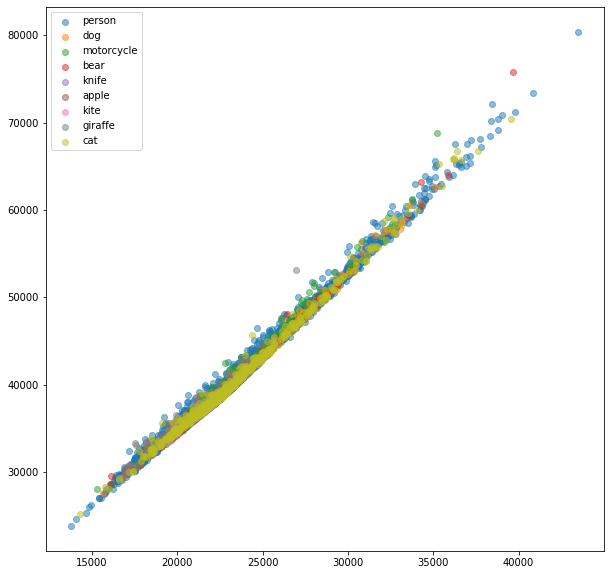

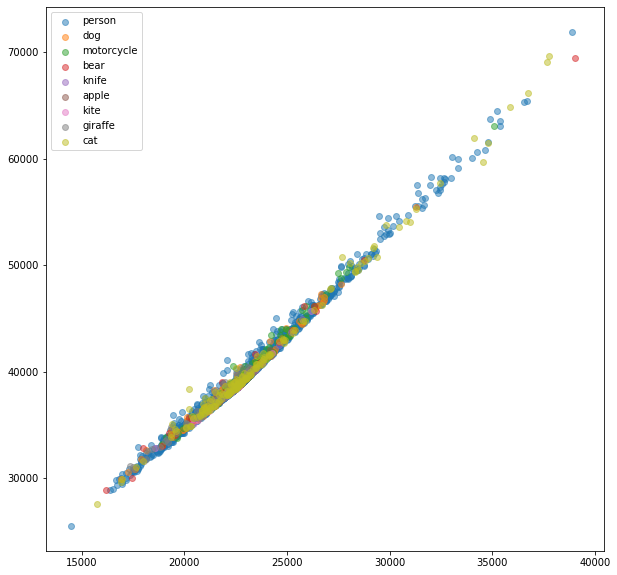

In [11]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(dev_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [12]:
torch.save(model.state_dict(), "siamese.pth")